# Análisis tramas BLE

## Introducción

Primer acercamiento al análisis de los datos generados por un módulo ESP32 encargado de capturar las tramas Bluetooth generadas por los dispositivos cercanos.
Este estudio tiene como objetivo identificar patrones en los que se relacionan los datos para así poder aplicar algoritmos de Machine Learning para ser capaz de predecir el número de personas en un recinto.

En primer, cargaremos un datasheet generado por los receptores y por otro sensor colocado en la entrada de la biblioteca capaz de contabilizar el número de personas que entran y salen. Veremos que aspecto tienen los datos:

In [558]:
#from google.colab import drive
#drive.mount('/content/drive')

In [559]:
#!pip install dython

In [560]:
import datetime as dt
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dython.nominal import associations
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [561]:
def cleanBLEData(dataPath, sampling):
    """Función que limpia los datos BLE brutos y guarda los resultados en un archivo CSV."""

    # Se obtiene la lista de archivos a procesar.
    dataPath = Path(dataPath)

    columns = ["Indice int. muestreo", "Timestamp int.", "Raspberry", "Nº Mensajes", "MAC",
               "Tipo MAC", "Tipo ADV", "BLE Size", "RSP Size", "BLE Data", "RSSI promedio"]

    stateColumns = ["Fecha", "Hora", "Indice intervalo", "RA(1/0)", "RB(1/0)", "RC(1/0)", "RD(1/0)", "RE(1/0)"]

    ids = ["Raspberry A", "Raspberry B", "Raspberry C", "Raspberry D", "Raspberry E"]

    dataList = []

    stateList = []

    # Para cada archivo disponible en la carpeta de datos.
    for file in dataPath.iterdir():
        dataBle = pd.read_csv(file, sep=";")

        # Se renombran los identificadores de las Raspberry Pi.
        dataBle["Id"] = dataBle["Id"].replace(["Raspberry1", "Raspberry2", "Raspberry3", "Raspberry5", "Raspberry7"],
                                              ["Raspberry A", "Raspberry D", "Raspberry B", "Raspberry E",
                                               "Raspberry C"])

        # Se añade columna Timestamp.
        dataBle["Timestamp"] = pd.to_datetime(dataBle["Fecha"] + " " + dataBle["Hora"], dayfirst=True)
        day = dataBle["Timestamp"].iloc[0].date().strftime("%Y-%m-%d")
        initDate = dataBle["Timestamp"].min()
        initDate = initDate - dt.timedelta(minutes=sampling - 1, seconds=59)
        endDate = dataBle["Timestamp"].max()
        dataBle["Mensajes"] = 1

        # Lista con todos los Timestamps posibles, añadiendoles índice.
        fullDateList = list(
            enumerate(pd.date_range(start=day + " 07:00:00", end=day + " 22:00:00", freq=str(sampling) + "T")))

        # Filtrado para obtener los Timestamps coincidentes con los datos
        dateList = np.array([x for x in fullDateList if initDate <= x[1] <= endDate])
        filterData = pd.DataFrame(columns=columns)
        stateData = pd.DataFrame(columns=stateColumns)

        # Se añaden los datos de las Raspberry Pi que no han enviado ningún mensaje.
        if dateList[0][0] != 0:
            datesNotWork = fullDateList[0:dateList[0][0]]
            for date in datesNotWork:
                stateData = stateData.append(
                    {"Fecha": date[1].strftime("%Y-%m-%d"), "Hora": date[1].strftime("%H:%M:%S"),
                     "Indice intervalo": date[0] + 1, "RA(1/0)": 0, "RB(1/0)": 0, "RC(1/0)": 0, "RD(1/0)": 0,
                     "RE(1/0)": 0}, ignore_index=True)

        # Para cada fecha disponible en la lista de fechas.
        for i, date in dateList:
            # Se obtiene la siguiente fecha a la actual. Se filtra el dataframe original entre cada pareja de fechas.
            nextDate = [x for x in dateList if x[0] == i + 1]
            try:
                group = dataBle.loc[(dataBle["Timestamp"] >= date) & (dataBle["Timestamp"] < nextDate[0][1])]
            except IndexError:
                break

            # Se agrupan los valores, calculando el promedio de RSSI.
            group = group.groupby(["Id", "MAC", "Tipo MAC", "Tipo ADV", "ADV Size", "RSP Size", "Advertisement"]).sum()
            group["RSSI promedio"] = np.round(group["RSSI"] / group["Mensajes"], 2)
            group["Timestamp"] = date.strftime("%Y-%m-%d %H:%M:%S")
            group["Indice int. muestreo"] = i + 1
            group.reset_index(inplace=True)

            # Se genera la lista de datos limpios y se añade al dataframe, concatenandolos al final.
            data = np.transpose(np.array(
                [group["Indice int. muestreo"], group["Timestamp"], group["Id"], group["Mensajes"], group["MAC"],
                 group["Tipo MAC"],
                 group["Tipo ADV"], group["ADV Size"], group["RSP Size"], group["Advertisement"],
                 group["RSSI promedio"]]))

            filtData = pd.DataFrame(data, columns=columns)
            filterData = pd.concat([filterData, filtData], ignore_index=True)

            # Se genera la lista de estados de las Raspberry, identificando la MAC de señalización y añadiendo el estado
            # de cada Raspberry.
            state = [date.strftime("%Y-%m-%d"), date.strftime("%H:%M:%S"), i + 1]
            flagGroup = group.loc[group["MAC"] == "00:00:00:00:00:00"]
            activeRaspberry = list(flagGroup["Id"].unique())
            raspberryStates = [1 if x in activeRaspberry else 0 for x in ids]
            state.extend(raspberryStates)

            state = pd.DataFrame([state], columns=stateColumns)
            stateData = pd.concat([stateData, state], ignore_index=True)

        dataList.append(filterData)
        stateList.append(stateData)

    return dataList, stateList


def setDateTimeLimits(data, values, day, isDf=True):
    """Función que devuelve un conjunto de datos con los límites de tiempo establecidos."""

    # Fecha y hora de inicio
    initDate = pd.to_datetime(day + " 07:00:00")
    endDate = pd.to_datetime(day + " 21:55:00")

    # Si el conjunto de datos es un DataFrame, se trata de manera distinta una Serie.
    # Se crea un Dataframe con los valores pasados por argumento junto al Timestamp de inicio y fin y se concatenan.
    if isDf:
        nanList = np.empty(len(data.columns))
        nanList[:] = values
        data.reset_index(inplace=True)
        initValues = [initDate] + list(nanList)
        endValues = [endDate] + list(nanList)
        dfInit = pd.DataFrame([initValues], columns=data.columns)
        dfEnd = pd.DataFrame([endValues], columns=data.columns)
        if initDate not in data["Timestamp"].unique():
            data = pd.concat([dfInit, data])

        if endDate not in data["Timestamp"].unique():
            data = pd.concat([data, dfEnd])
        data.set_index("Timestamp", inplace=True)

    # En caso de una Serie, se crea una Serie con los valores pasados por argumento junto al Timestamp de inicio y fin
    # y se concatenan.
    else:
        dfInit = pd.Series(values, index=[initDate], name="Timestamp")
        dfEnd = pd.Series(values, index=[endDate], name="Timestamp")
        if initDate not in data:
            data = pd.concat([dfInit, data])

        if endDate not in data:
            data = pd.concat([data, dfEnd])

    return data


def readAndPrepareDataFromDirectory(dataPath, personCountPath, sampling):
    """Función que lee los archivos de datos de los receptores Bluetooth y del contador de personas y los concentra en un array."""

    # Todos los archivos csv se cargarán dentro de una lista para ser utilizados posteriormente.
    dataArray = []
    personCountArray = []
    stateArray = []
    personCountPath = Path(personCountPath)

    dataList, stateList = cleanBLEData(dataPath, sampling)

    # Para los datos BLE, se cargan las columnas necesarias y eliminamos MAC de señalización.
    for data in dataList:
        data["Timestamp int."] = pd.to_datetime(data["Timestamp int."], dayfirst=True)
        data = data.rename(columns={"Timestamp int.": "Timestamp"})
        data = data.drop(data[data["MAC"] == "00:00:00:00:00:00"].index).reset_index(drop=True)
        data.set_index("Timestamp", inplace=True)
        dataArray.append(data)

    # Para los datos del contador de personas, generando la columna Timestamp y agrupando los valores en intervalos de 5
    # minutos. En esta carga en el caso de generar un valor nulo, se interpola en caso de ser hora de estudio y posteiriormente,
    # se rellena con valores nulos para tener el mismo número de intervalos temporales que los datos BLE.
    for file in personCountPath.iterdir():
        personCount = pd.read_csv(file, sep=";")
        personCount["Timestamp"] = personCount["Fecha"] + " " + personCount["Hora"]
        personCount.drop(columns=["Fecha", "Hora"], inplace=True)
        personCount["Timestamp"] = pd.to_datetime(personCount["Timestamp"], dayfirst=True)

        # Si existe la columna Sensor, debe tratarse de manera distinta.
        if "Sensor" in personCount.columns:
            personCount = personCount.drop(personCount[personCount["Sensor"] == "KeepAlive"].index)
            personCount.replace({"Right2": "Right"}, inplace=True)
            personCount.drop_duplicates(subset=["Timestamp", "Sensor"], keep="first", inplace=True)
        personCount["Ocupacion"] = (2 * personCount["Evento In-Out(1/0)"].astype(int) - 1).cumsum()

        # Se rellena e interpola los intervalos dentro de la ventana de estudio.
        personCount = personCount.groupby(pd.Grouper(key="Timestamp", freq=str(sampling) + "T")).last().fillna(
            method="ffill")
        personCount = personCount.round()

        # Se rellena los intervalos fuera de la ventana de estudio con valores nulos.
        day = personCount.index.date[0].strftime(format="%Y-%m-%d")
        personCount = personCount.loc[:, "Ocupacion"]
        personCount = setDateTimeLimits(personCount, np.nan, day, False)
        personCount = personCount.resample(str(sampling) + "T").asfreq()

        personCountArray.append(personCount)

    # Para los datos del estado de las Raspberry, se genera la columna Timestamp y se eliminan las que no son necesarias.
    for file in stateList:
        state = file.copy()
        state.insert(0, "Timestamp", state["Fecha"].str.cat(state["Hora"], sep=" "))
        state.drop(columns=["Fecha", "Hora", "Indice intervalo"], inplace=True)
        state["Timestamp"] = pd.to_datetime(state["Timestamp"], dayfirst=True)
        state.set_index("Timestamp", inplace=True)
        stateArray.append(state)

    return dataArray, personCountArray, stateArray


def uniqueValues(data):
    """Función que imprime el total de valores únicos de cada columna del conjunto de datos."""

    for file in data:
        day = file.index[0].date().strftime("%Y-%m-%d")
        print(file.nunique().sort_values())
        print("")
        print(f"Número de filas total para el día {day}: {file.shape[0]}")


def totalDevicesSummary(data):
    """Función que imprime un resumen del número total de dispositivos captados globalmente y por Raspberry."""

    for file in data:
        MACByRasp = file.groupby("Raspberry").nunique()["MAC"].sort_index()
        sumTotalDevices = 0
        for i in range(np.shape(MACByRasp)[0]):
            print(f"Número de dispositivos únicos captados por la {MACByRasp.index[i]}: {MACByRasp[i]}")
            sumTotalDevices = sumTotalDevices + MACByRasp[i]
        totalDevices = len(file["MAC"].unique())
        print(f"Sumatorio del número total de dispositivos únicos captados por cada receptor: {sumTotalDevices}")
        print(f"Número total de dispositivos únicos captados: {totalDevices}")


def plotRandomPublicMAC(data):
    """Función que representa un histograma con la cantidad de dispositivos con MAC Random y Pública."""

    for file in data:
        MACTypeData = file.groupby("Tipo MAC").nunique()
        plt.bar(MACTypeData.index, MACTypeData["MAC"])
        plt.xlabel("MAC Address Type")
        plt.ylabel("MAC Address's Number")
        plt.title("Random vs Public MAC Address")
        plt.grid()
        plt.show()


def plotTotalDevices(data, personCount, sampling):
    """Función que representa el número de dispositivos únicos captados en cada intervalo de tiempo."""

    for i in range(len(data)):
        groupData = data[i].reset_index()
        groupPC = personCount[i]
        day = groupData["Timestamp"].iloc[0].date().strftime("%Y-%m-%d")
        nDevices = groupData.groupby("Timestamp").nunique()
        nDevices = setDateTimeLimits(nDevices, np.nan, day)
        nDevices = nDevices.resample(str(sampling) + "T").mean().interpolate()
        nDevicesRand = groupData.loc[groupData["Tipo MAC"] == "Random"].groupby("Timestamp").nunique()
        nDevicesRand = setDateTimeLimits(nDevicesRand, np.nan, day)
        nDevicesRand = nDevicesRand.resample(str(sampling) + "T").mean().interpolate()

        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(nDevices.index, nDevices["MAC"], color="blue", label="Public+Random")
        plt.plot(nDevicesRand.index, nDevicesRand["MAC"], color="green", label="Random")
        plt.plot(groupPC.index, groupPC.values, color="red", label="Person Count")
        plt.xlabel("Timestamp")
        plt.ylabel("Devices and People")
        plt.title(f"Device's Number along Time {day}")
        plt.legend()
        plt.grid()
        plt.show()


def parseDataByRaspberry(data):
    """Función que devuelve un conjunto de datos filtrado por cada Raspberry. Devuelve un conjunto por Raspberry."""

    dataCopy = data.copy()
    dataRA = dataCopy.loc[dataCopy["Raspberry"] == "Raspberry A"]
    dataRB = dataCopy.loc[dataCopy["Raspberry"] == "Raspberry B"]
    dataRC = dataCopy.loc[dataCopy["Raspberry"] == "Raspberry C"]
    dataRD = dataCopy.loc[dataCopy["Raspberry"] == "Raspberry D"]
    dataRE = dataCopy.loc[dataCopy["Raspberry"] == "Raspberry E"]

    return dataRA, dataRB, dataRC, dataRD, dataRE


def groupDataByRaspberryTime(data):
    """Función que devuelve conjuntos de datos con valores únicos filtrados por Raspberry y agrupados por Timestamp."""

    dataRA, dataRB, dataRC, dataRD, dataRE = parseDataByRaspberry(data)

    dataRA = dataRA.groupby("Timestamp").nunique()
    dataRB = dataRB.groupby("Timestamp").nunique()
    dataRC = dataRC.groupby("Timestamp").nunique()
    dataRD = dataRD.groupby("Timestamp").nunique()
    dataRE = dataRE.groupby("Timestamp").nunique()

    return dataRA, dataRB, dataRC, dataRD, dataRE


def getTotalDeviceNumberByRaspberry(data):
    """Función que devuelve el número de dispositivos en cada intervalo de tiempo para cada Raspberry."""

    dataRA, dataRB, dataRC, dataRD, dataRE = parseDataByRaspberry(data)

    nDevicesRA = dataRA.groupby("Timestamp").count()
    nDevicesRB = dataRB.groupby("Timestamp").count()
    nDevicesRC = dataRC.groupby("Timestamp").count()
    nDevicesRD = dataRD.groupby("Timestamp").count()
    nDevicesRE = dataRE.groupby("Timestamp").count()

    return nDevicesRA, nDevicesRB, nDevicesRC, nDevicesRD, nDevicesRE


def plotTotalDevicesByRaspberry(data, personCount, state, sampling, initHour=None, endHour=None):
    """Función que representa el número de dispositivos en cada intervalo de tiempo para cada Raspberry."""

    for i in range(len(data)):
        groupData = data[i]
        groupPC = personCount[i]
        groupState = state[i]

        RADownInterval = groupState.loc[groupState["RA(1/0)"] == 0].index
        RBDownInterval = groupState.loc[groupState["RB(1/0)"] == 0].index
        RCDownInterval = groupState.loc[groupState["RC(1/0)"] == 0].index
        RDDownInterval = groupState.loc[groupState["RD(1/0)"] == 0].index
        REDownInterval = groupState.loc[groupState["RE(1/0)"] == 0].index
        RDownInterval = (RADownInterval, RBDownInterval, RCDownInterval, RDDownInterval, REDownInterval)

        raspList = list(getTotalDeviceNumberByRaspberry(groupData))
        raspFullList = []
        day = groupData.index[0].date().strftime("%Y-%m-%d")

        for j in range(len(raspList)):
            file = setDateTimeLimits(raspList[j], np.nan, day)
            file = file.resample(str(sampling) + "T").mean().interpolate()
            file.loc[RDownInterval[i], "MAC"] = np.nan
            raspFullList.append(file)

        dataRA, dataRB, dataRC, dataRD, dataRE = raspFullList

        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(dataRA.index, dataRA["MAC"], color="blue", label="Raspberry A")
        plt.plot(dataRB.index, dataRB["MAC"], color="green", label="Raspberry B")
        plt.plot(dataRC.index, dataRC["MAC"], color="purple", label="Raspberry C")
        plt.plot(dataRD.index, dataRD["MAC"], color="deeppink", label="Raspberry D")
        plt.plot(dataRE.index, dataRE["MAC"], color="gold", label="Raspberry E")
        plt.plot(groupPC.index, groupPC, color="red", label="Person Count")
        plt.xlabel("Timestamp")
        plt.ylabel("Devices and People")
        plt.title(f"Device's Number along Time per Raspberry {day}")
        if (initHour is not None) and (endHour is not None):
            initialDate = dt.datetime(groupData.index[0].year, groupData.index[0].month, groupData.index[0].day,
                                      hour=initHour)
            finalDate = dt.datetime(groupData.index[0].year, groupData.index[0].month, groupData.index[0].day,
                                    hour=endHour)
            plt.xlim(initialDate, finalDate)
        plt.legend()
        plt.grid()
        plt.show()


def devicesOffset(data, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True):
    """Función que calcula los dispositivos medios en dos intervalos de tiempo."""

    devicesFirstHourDataframeList = []
    nDevicesFirstHourList = []
    devicesSecondHourDataframeList = []
    nDevicesSecondHourList = []

    for file in data:

        dataCopy = file.copy()
        dataCopy.reset_index(inplace=True)
        day = dataCopy["Timestamp"][0].date().strftime("%Y-%m-%d")
        initFirst = pd.to_datetime(day + " " + firstValue)
        initSecond = pd.to_datetime(day + " " + secondValue)
        endFirst = initFirst + dt.timedelta(minutes=interval)
        endSecond = initSecond + dt.timedelta(minutes=interval)
        nDevicesFirstHour = dataCopy[
            (dataCopy["Timestamp"] >= initFirst) & (dataCopy["Timestamp"] <= endFirst)]
        nDevicesSecondHour = dataCopy[
            (dataCopy["Timestamp"] >= initSecond) & (dataCopy["Timestamp"] <= endSecond)]
        nDevicesFirstHour = nDevicesFirstHour.groupby(["Timestamp", "MAC"]).sum()
        nDevicesSecondHour = nDevicesSecondHour.groupby(["Timestamp", "MAC"]).sum()

        totalTimestampsFirstHour = len(nDevicesFirstHour.index.get_level_values(0).unique())
        limitFirstHour = int(np.round(totalTimestampsFirstHour * threshold / 100))
        totalTimestampsSecondHour = len(nDevicesSecondHour.index.get_level_values(0).unique())
        limitSecondHour = int(np.round(totalTimestampsSecondHour * threshold / 100))

        macsFirstHour = pd.DataFrame(nDevicesFirstHour.index.get_level_values(1), columns=["MAC"])
        macsSecondHour = pd.DataFrame(nDevicesSecondHour.index.get_level_values(1), columns=["MAC"])
        macsFirstHour = macsFirstHour["MAC"].value_counts()
        macsSecondHour = macsSecondHour["MAC"].value_counts()

        devicesFirstHourDataframe = macsFirstHour.loc[macsFirstHour >= limitFirstHour]
        nDevicesFirstHour = len(devicesFirstHourDataframe)
        devicesSecondHourDataframe = macsSecondHour.loc[macsSecondHour >= limitSecondHour]
        nDevicesSecondHour = len(devicesSecondHourDataframe)

        devicesFirstHourDataframeList.append(devicesFirstHourDataframe)
        nDevicesFirstHourList.append(nDevicesFirstHour)
        devicesSecondHourDataframeList.append(devicesSecondHourDataframe)
        nDevicesSecondHourList.append(nDevicesSecondHour)

        if show:
            print(
                f"Número de dispositivos entre las {firstValue} y las {endFirst.time().strftime('%H:%M:%S')} del día {day}: {str(nDevicesFirstHour)}")
            print(
                f"Número de dispositivos entre las {secondValue} y las {endSecond.time().strftime('%H:%M:%S')} del día {day}: {str(nDevicesSecondHour)}")
            print("")

    return devicesFirstHourDataframeList, nDevicesFirstHourList, devicesSecondHourDataframeList, nDevicesSecondHourList


def errorCalc(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True):
    """Función que devuelve el error medio, el error cuadrático medio y la varianza entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    metricsDf = pd.DataFrame(columns=["Date", "Error", "Quadratic Error", "Variance"])

    for i in range(len(data)):
        groupData = data[i]
        groupPC = personCount[i]
        groupData = groupData.groupby("Timestamp").nunique()
        date = groupData.index[0].date().strftime("%Y-%m-%d")
        groupData = setDateTimeLimits(groupData, np.nan, date)
        groupData = groupData.resample(str(sampling) + "T").mean().interpolate()
        init = pd.to_datetime(date + " " + startHour)
        end = pd.to_datetime(date + " " + finalHour)
        groupData = groupData.loc[init:end]
        groupData.dropna(inplace=True)
        datesData = groupData.index
        groupPC = groupPC.loc[init:end]
        groupPC.dropna(inplace=True)
        datesPC = groupPC.index
        dates = set(datesData) & set(datesPC)
        groupData = groupData.loc[dates]
        groupPC = groupPC.loc[dates]
        errorInterval = groupData["MAC"].values - groupPC
        error = np.round(errorInterval.mean(), 3)
        quadraticError = np.round(mean_squared_error(groupData["MAC"].values, groupPC), 3)
        variance = np.round(np.var(errorInterval))
        df = pd.DataFrame([[date, error, quadraticError, variance]],
                          columns=["Date", "Error", "Quadratic Error", "Variance"])
        metricsDf = pd.concat([metricsDf, df], ignore_index=True)

        if show:
            print(f"El error medio del día es: {error}")
            print(f"El error cuadrático medio del día es: {quadraticError}")
            print(f"La varianza del error del día es: {variance}")

    metricsDf.set_index("Date", inplace=True)

    return metricsDf


def deviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True, offset=False,
                firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False):
    """Función que devuelve la relación (ratio) entre el número de dispositivos captados y el número de personas contadas por el contador de personas."""

    ratioDfList = []
    ratioMeanDf = pd.DataFrame(columns=["Date", "Ratio"])

    for i in range(len(data)):
        groupData = data[i]
        groupPC = personCount[i]
        groupData = groupData.groupby("Timestamp").nunique()
        date = groupData.index[0].date().strftime("%Y-%m-%d")
        groupData = setDateTimeLimits(groupData, np.nan, date)
        groupData = groupData.resample(str(sampling) + "T").mean().interpolate()
        init = date + " " + startHour
        end = date + " " + finalHour
        groupData = groupData.loc[init:end]
        groupData.dropna(inplace=True)
        datesData = groupData.index
        groupPC = groupPC.loc[init:end]
        groupPC.dropna(inplace=True)
        datesPC = groupPC.index
        dates = list(set(datesData) & set(datesPC))
        groupData = groupData.loc[dates]
        groupPC = groupPC.loc[dates]

        if offset:
            _, devicesFirstHour, _, devicesSecondHour = devicesOffset(data, firstValue, secondValue, interval,
                                                                      threshold, showDetail)
            deviceOffset = np.round(np.mean([devicesFirstHour, devicesSecondHour]))
            groupData["MAC"] = groupData.apply(lambda x: x["MAC"] - deviceOffset, axis=1)

        ratioList = [x / y if y > 0 else 0 for x, y in zip(groupData["MAC"].values, groupPC.values)]
        ratioList = np.round(ratioList, 2)
        dataRatioDf = np.transpose(np.array([dates, ratioList], dtype=object))
        ratioDataframe = pd.DataFrame(dataRatioDf, columns=["Timestamp", "Ratio"])
        ratioDataframe.set_index("Timestamp", inplace=True)
        ratioDataframe.sort_index(inplace=True)
        ratioDfList.append(ratioDataframe)
        ratio = np.round(np.mean(ratioList), 2)
        df = pd.DataFrame([[date, ratio]], columns=["Date", "Ratio"])
        ratioMeanDf = pd.concat([ratioMeanDf, df], ignore_index=True)

        if show:
            print(f"El ratio medio para el día {date} es: {str(ratio)}")

    ratioMeanDf.set_index("Date", inplace=True)
    ratioMeanDf.sort_index(inplace=True)

    return ratioDfList, ratioMeanDf


def plotDeviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, offset=False,
                    firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False):
    """Función que representa la relación (ratio) entre el número de dispositivos captados y el número de personas contadas por el contador de personas"""

    ratioDfList, _ = deviceRatio(data, personCount, sampling, startHour, finalHour, show, offset, firstValue,
                                 secondValue, interval, threshold, showDetail)

    for file in ratioDfList:
        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(file.index, file["Ratio"])
        plt.xlabel("Timestamp")
        plt.ylabel("Ratio")
        plt.title(f"Device's Number / Person Count Ratio {file.index[0].strftime('%Y-%m-%d')}")
        plt.grid()
        plt.show()


def plotPersonCountRatio(personCount, ratioDataframe):
    """Función que representa el ratio y el número de personas en función del tiempo."""

    for i in range(len(personCount)):
        groupPC = personCount[i]
        ratio = ratioDataframe[i]
        start = ratio.index[0]
        end = ratio.index[-1]
        groupPC = groupPC.loc[start:end]
        plt.subplots(figsize=(10, 6))
        plt.scatter(groupPC.values, ratio["Ratio"].values)
        plt.xlabel("Person Count")
        plt.ylabel("Ratio")
        plt.title(f"Number of People vs Ratio {ratio.index[0].strftime('%Y-%m-%d')}")
        plt.grid()
        plt.show()


def tableMetricList(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False,
                    firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, offset=False,
                    showDetail=False):
    """Función que calcula métricas como el error, ratio y offset para varios días."""

    tableMetrics = pd.DataFrame(columns=["Date", "Start Hour", "End Hour", "Error", "Ratio", "Offset"])

    metrics = errorCalc(data, personCount, sampling, startHour, finalHour, show)
    _, ratio = deviceRatio(data, personCount, sampling, startHour, finalHour, show, offset, firstValue, secondValue,
                           interval, threshold, showDetail)
    _, devicesFirstHour, _, devicesSecondHour = devicesOffset(data, firstValue, secondValue, interval, threshold, show)
    startHour = [startHour for _ in range(len(metrics))]
    finalHour = [finalHour for _ in range(len(metrics))]
    dataDf = np.transpose(np.array([metrics.index, startHour, finalHour, metrics["Error"].values, ratio["Ratio"].values,
                                    np.round(np.mean([devicesFirstHour, devicesSecondHour], axis=0))]))

    df = pd.DataFrame(dataDf, columns=["Date", "Start Hour", "End Hour", "Error", "Ratio", "Offset"])
    tableMetrics = pd.concat([tableMetrics, df], ignore_index=True)
    tableMetrics.set_index("Date", inplace=True)
    print(tableMetrics)

    return tableMetrics


def plotSummaryDay(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, offset=False,
                   firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False):
    """Función que representa para cada día el número de dispositivos, el ratio y la dispersion del ratio en función del tiempo."""

    ratioDataframe, _ = deviceRatio(data, personCount, sampling, startHour, finalHour, show, offset, firstValue,
                                    secondValue, interval, threshold, showDetail)
    plotTotalDevices(data, personCount, sampling)
    plotDeviceRatio(data, personCount, sampling, startHour, finalHour, show, True, firstValue, secondValue, interval,
                    threshold, showDetail)
    plotPersonCountRatio(personCount, ratioDataframe)


def rssiCalc(data, initValue=10, endValue=50):
    """Función que calcula el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables."""

    rssiInterval1List = []
    rssiInterval2List = []
    rssiInterval3List = []
    rssiInterval4List = []
    rssiInterval5List = []
    rssiInterval6List = []

    values = np.round(np.linspace(initValue, endValue, 5) / 100, 2)

    for file in data:
        minRSSI = file["RSSI promedio"].min()

        rssiInterval1 = file.loc[(file["RSSI promedio"] <= minRSSI - minRSSI * values[0])]
        rssiInterval1 = rssiInterval1.groupby("Timestamp").count()
        rssiInterval1List.append(rssiInterval1)

        rssiInterval2 = file.loc[(file["RSSI promedio"] > minRSSI - minRSSI * values[0]) & (
                file["RSSI promedio"] <= minRSSI - minRSSI * values[1])]
        rssiInterval2 = rssiInterval2.groupby("Timestamp").count()
        rssiInterval2List.append(rssiInterval2)

        rssiInterval3 = file.loc[(file["RSSI promedio"] > minRSSI - minRSSI * values[1]) & (
                file["RSSI promedio"] <= minRSSI - minRSSI * values[2])]
        rssiInterval3 = rssiInterval3.groupby("Timestamp").count()
        rssiInterval3List.append(rssiInterval3)

        rssiInterval4 = file.loc[(file["RSSI promedio"] > minRSSI - minRSSI * values[2]) & (
                file["RSSI promedio"] <= minRSSI - minRSSI * values[3])]
        rssiInterval4 = rssiInterval4.groupby("Timestamp").count()
        rssiInterval4List.append(rssiInterval4)

        rssiInterval5 = file.loc[(file["RSSI promedio"] > minRSSI - minRSSI * values[3]) & (
                file["RSSI promedio"] <= minRSSI - minRSSI * values[4])]
        rssiInterval5 = rssiInterval5.groupby("Timestamp").count()
        rssiInterval5List.append(rssiInterval5)

        rssiInterval6 = file.loc[file["RSSI promedio"] > minRSSI - minRSSI * values[4]]
        rssiInterval6 = rssiInterval6.groupby("Timestamp").count()
        rssiInterval6List.append(rssiInterval6)

    return rssiInterval1List, rssiInterval2List, rssiInterval3List, rssiInterval4List, rssiInterval5List, rssiInterval6List, values * 100


def plotTotalDevicesByRSSI(data, initValue=10, endValue=50):
    """Función que representa el número de dispositivos cuyos mensajes se encuentran en unos umbrales de potencia modificables."""

    rssiInterval1, rssiInterval2, rssiInterval3, rssiInterval4, rssiInterval5, rssiInterval6, values = rssiCalc(data,
                                                                                                                initValue,
                                                                                                                endValue)

    for i in range(len(rssiInterval1)):
        int1 = rssiInterval1[i]
        int2 = rssiInterval2[i]
        int3 = rssiInterval3[i]
        int4 = rssiInterval4[i]
        int5 = rssiInterval5[i]
        int6 = rssiInterval6[i]

        date = int1.index[0].strftime("%Y-%m-%d")

        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(int1.index, int1["MAC"], color="blue", label=f"RSSI <= {str(values[0])}%")
        plt.plot(int2.index, int2["MAC"], color="green", label=f"{str(values[0])}% < RSSI <= {str(values[1])}%")
        plt.plot(int3.index, int3["MAC"], color="purple", label=f"{str(values[1])}% < RSSI <= {str(values[2])}%")
        plt.plot(int4.index, int4["MAC"], color="deeppink", label=f"{str(values[2])}% < RSSI <= {str(values[3])}%")
        plt.plot(int5.index, int5["MAC"], color="gold", label=f"{str(values[3])}% < RSSI <= {str(values[4])}%")
        plt.plot(int6.index, int6["MAC"], color="red", label=f"{str(values[4])}% < RSSI")
        plt.xlabel("Timestamp")
        plt.ylabel("Device's Number")
        plt.title(f"Device's Number by RSSI Level {date}")
        plt.legend()
        plt.grid()
        plt.show()


def histTotalDevicesByRSSIAndRaspberry(data, bins=20):
    """Función que representa en forma de histograma la cantidad de dispositivos comprendidos entre el nivel de señal mínimo y máximo."""

    for file in data:
        date = file.index[0].strftime("%Y-%m-%d")

        dataRA, dataRB, dataRC, dataRD, dataRE = parseDataByRaspberry(file)

        dataRA = dataRA.groupby("MAC").mean()
        dataRB = dataRB.groupby("MAC").mean()
        dataRC = dataRC.groupby("MAC").mean()
        dataRD = dataRD.groupby("MAC").mean()
        dataRE = dataRE.groupby("MAC").mean()

        figure, axis = plt.subplots(5, 1, sharex="all", sharey="all")
        figure.set_size_inches(10, 15)
        axis[0].hist(dataRA["RSSI promedio"], bins, color="blue")
        axis[0].set_title(f"Raspberry A {date}")
        axis[1].hist(dataRB["RSSI promedio"], bins, color="green")
        axis[1].set_title("Raspberry B")
        axis[2].hist(dataRC["RSSI promedio"], bins, color="red")
        axis[2].set_title("Raspberry C")
        axis[3].hist(dataRD["RSSI promedio"], bins, color="deeppink")
        axis[3].set_title("Raspberry D")
        axis[4].hist(dataRE["RSSI promedio"], bins, color="gold")
        axis[4].set_title("Raspberry E")


def messageCalc(data, initValue=25, endValue=125):
    """Función que devuelve el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo."""

    values = np.linspace(initValue, endValue, 5)
    values = values.astype(int)

    messageInterval1List = []
    messageInterval2List = []
    messageInterval3List = []
    messageInterval4List = []
    messageInterval5List = []
    messageInterval6List = []

    for file in data:
        messageInterval1 = file.loc[(file["Nº Mensajes"] <= values[0])]
        messageInterval1 = messageInterval1.groupby("Timestamp").count()
        messageInterval1List.append(messageInterval1)

        messageInterval2 = file.loc[(file["Nº Mensajes"] > values[0]) & (file["Nº Mensajes"] <= values[1])]
        messageInterval2 = messageInterval2.groupby("Timestamp").count()
        messageInterval2List.append(messageInterval2)

        messageInterval3 = file.loc[(file["Nº Mensajes"] > values[1]) & (file["Nº Mensajes"] <= values[2])]
        messageInterval3 = messageInterval3.groupby("Timestamp").count()
        messageInterval3List.append(messageInterval3)

        messageInterval4 = file.loc[(file["Nº Mensajes"] > values[2]) & (file["Nº Mensajes"] <= values[3])]
        messageInterval4 = messageInterval4.groupby("Timestamp").count()
        messageInterval4List.append(messageInterval4)

        messageInterval5 = file.loc[(file["Nº Mensajes"] > values[3]) & (file["Nº Mensajes"] <= values[4])]
        messageInterval5 = messageInterval5.groupby("Timestamp").count()
        messageInterval5List.append(messageInterval5)

        messageInterval6 = file.loc[file["Nº Mensajes"] > values[4]]
        messageInterval6 = messageInterval6.groupby("Timestamp").count()
        messageInterval6List.append(messageInterval6)

    return messageInterval1List, messageInterval2List, messageInterval3List, messageInterval4List, messageInterval5List, messageInterval6List, values


def plotTotalDevicesByMessage(data, personCount, initValue=25, endValue=125, name=None):
    """Función que representa el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo."""

    messageInterval1, messageInterval2, messageInterval3, messageInterval4, messageInterval5, messageInterval6, values = messageCalc(
        data, initValue, endValue)

    values = values.astype(str)

    for i in range(len(messageInterval1)):

        groupPC = personCount[i]
        mes1 = messageInterval1[i]
        mes2 = messageInterval2[i]
        mes3 = messageInterval3[i]
        mes4 = messageInterval4[i]
        mes5 = messageInterval5[i]
        mes6 = messageInterval6[i]

        date = mes1.index[0].strftime("%Y-%m-%d")

        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(mes1.index, mes1["Nº Mensajes"], color="blue", label=f"nMessage <= {values[0]}")
        plt.plot(mes2.index, mes2["Nº Mensajes"], color="green", label=f"{values[0]} < nMessage <= {values[1]}")
        plt.plot(mes3.index, mes3["Nº Mensajes"], color="purple", label=f"{values[1]} < nMessage <= {values[2]}")
        plt.plot(mes4.index, mes4["Nº Mensajes"], color="deeppink", label=f"{values[2]} < nMessage <= {values[3]}")
        plt.plot(mes5.index, mes5["Nº Mensajes"], color="gold", label=f"{values[3]} < nMessage <= {values[4]}")
        plt.plot(mes6.index, mes6["Nº Mensajes"], color="red", label=f"{values[4]} < nMessage")
        plt.plot(groupPC.index, groupPC.values, color="cyan", label="Person Count")
        plt.xlabel("Timestamp")
        plt.ylabel("Device's Number")
        if name is None:
            plt.title(f"Number of Devices by Message's Number {date}")
        else:
            plt.title(f"Number of Devices by Message's Number in {name} {date}")
        plt.legend()
        plt.grid()
        plt.show()


def plotTotalDevicesByMessageByRaspberry(data, personCount, initValue=25, endValue=125):
    """Función que representa el número de dispositivos que se encuentran en unos umbrales en función del número de mensajes en cada intervalo de tiempo para cada una de las Raspberry"""

    for i in range(len(data)):
        groupData = data[i]
        groupPC = personCount[i]

        dataRA, dataRB, dataRC, dataRD, dataRE = parseDataByRaspberry(groupData)

        plotTotalDevicesByMessage([dataRA], [groupPC], initValue, endValue, "Raspberry A")
        plotTotalDevicesByMessage([dataRB], [groupPC], initValue, endValue, "Raspberry B")
        plotTotalDevicesByMessage([dataRC], [groupPC], initValue, endValue, "Raspberry C")
        plotTotalDevicesByMessage([dataRD], [groupPC], initValue, endValue, "Raspberry D")
        plotTotalDevicesByMessage([dataRE], [groupPC], initValue, endValue, "Raspberry E")


def getMetricsRoom(data, RSSIThreshold=-99):
    """Función que muestra métricas únicamente de la sala de estudio, como número de dispositivos captados por Raspberry, número de mensajes captados por Raspberry, tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de mensajes y tanto por ciento de dispositivos con mensajes por debajo de cierto umbral de potencia."""

    for file in data:
        date = file.index[0].strftime("%Y-%m-%d")

        print(f"Métricas para el día {date}")
        print("")

        _, _, dataRC, dataRD, dataRE = parseDataByRaspberry(file)

        nDevicesRC = dataRC["MAC"].nunique()
        nDevicesRD = dataRD["MAC"].nunique()
        nDevicesRE = dataRE["MAC"].nunique()

        print(f"Número dispositivos captados por la Raspberry C: {nDevicesRC}")
        print(f"Número dispositivos captados por la Raspberry D: {nDevicesRD}")
        print(f"Número dispositivos captados por la Raspberry E: {nDevicesRE}")
        print("")

        nMessageRC = dataRC["Nº Mensajes"].sum()
        nMessageRD = dataRD["Nº Mensajes"].sum()
        nMessageRE = dataRE["Nº Mensajes"].sum()
        print(f"Número de mensajes captados por la Raspberry C: {nMessageRC}")
        print(f"Número de mensajes captados por la Raspberry D: {nMessageRD}")
        print(f"Número de mensajes captados por la Raspberry E: {nMessageRE}")
        print("")

        filterRC = dataRC.loc[dataRC["RSSI promedio"] < RSSIThreshold]
        nMessageFilterRC = filterRC["Nº Mensajes"].sum()

        filterRD = dataRD.loc[dataRD["RSSI promedio"] < RSSIThreshold]
        nMessageFilterRD = filterRD["Nº Mensajes"].sum()

        filterRE = dataRE.loc[dataRE["RSSI promedio"] < RSSIThreshold]
        nMessageFilterRaspberry7 = filterRE["Nº Mensajes"].sum()

        print(
            f"Tanto por ciento de mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry C: {np.round(nMessageFilterRC / nMessageRC * 100, 4)}%")
        print(
            f"Tanto por ciento de mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry D: {np.round(nMessageFilterRD / nMessageRD * 100, 4)}%")
        print(
            f"Tanto por ciento de mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry E: {np.round(nMessageFilterRaspberry7 / nMessageRE * 100, 4)}")
        print("")

        nDeviceRC = dataRC["MAC"].count()
        nDeviceRD = dataRD["MAC"].count()
        nDeviceRE = dataRE["MAC"].count()
        nDeviceFilterRC = filterRC["MAC"].count()
        nDeviceFilterRD = filterRD["MAC"].count()
        nDeviceFilterRE = filterRE["MAC"].count()
        print(
            f"Tanto por ciento de dispositivos con mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry C: {np.round(nDeviceFilterRC / nDeviceRC * 100, 4)}%")
        print(
            f"Tanto por ciento de dispositivos con mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry D: {np.round(nDeviceFilterRD / nDeviceRD * 100, 4)}%")
        print(
            f"Tanto por ciento de dispositivos con mensajes por debajo de {str(RSSIThreshold)} dB en Raspberry E: {np.round(nDeviceFilterRE / nDeviceRE * 100, 4)}%")
        print("")


def devicesOverlapRoom(data, sampling):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos que muestran por cuantas Raspberry ha sido captado un dispositivo, además de distinguir por cuál de ellas.
     También para el caso especial de ser captado por todas, por la pareja CE o la pareja DE.
     Por último el tanto por ciento de direcciones registradas por todas las anteriores posibilidades por separado."""

    deviceSummaryList = []
    deviceOverlapList = []
    deviceOverlapRateList = []

    for file in data:

        _, _, dataRC, dataRD, dataRE = parseDataByRaspberry(file)

        dataRC = dataRC[["Raspberry", "MAC"]]
        dataRD = dataRD[["Raspberry", "MAC"]]
        dataRE = dataRE[["Raspberry", "MAC"]]

        nDevicesIntervalDataRDEMerge = dataRD.merge(dataRE, how="outer", on=("Timestamp", "MAC"), copy=False,
                                                    suffixes=("_d", "_e"))
        nDevicesIntervalDataRCDEMerge = nDevicesIntervalDataRDEMerge.merge(dataRC, how="outer", on=("Timestamp", "MAC"),
                                                                           copy=False)

        group = nDevicesIntervalDataRCDEMerge.groupby(["Timestamp", "MAC"]).nunique()
        group["Total"] = group["Raspberry"] + group["Raspberry_d"] + group["Raspberry_e"]
        date = group.index.get_level_values(0).date[0].strftime(format="%Y-%m-%d")

        group_CDE = group.loc[(group["Raspberry"] == 1) & (group["Raspberry_d"] == 1) & (group["Raspberry_e"] == 1)]
        group_CE = group.loc[(group["Raspberry"] == 1) & (group["Raspberry_e"] == 1)]
        group_DE = group.loc[(group["Raspberry_d"] == 1) & (group["Raspberry_e"] == 1)]

        group.reset_index(inplace=True)
        deviceSummary = group[["Timestamp", "MAC", "Total"]]
        deviceSummary.set_index("Timestamp", inplace=True)
        deviceSummaryList.append(deviceSummary)

        dataList = [group_CDE, group_CE, group_DE]
        finalDataList = []

        for i, column in enumerate(dataList):
            column.reset_index(inplace=True)
            column = column["Timestamp"].value_counts(sort=False)
            column = setDateTimeLimits(column, 0, date, False)
            column = column.resample(str(sampling) + "T").asfreq().fillna(0)
            finalDataList.append(column)

        totalMACRCDE, totalMACRCE, totalMACRDE = finalDataList

        overlapData = np.transpose(
            np.array([totalMACRCDE.index, totalMACRCDE.values, totalMACRCE.values, totalMACRDE.values], dtype=object))
        deviceOverlap = pd.DataFrame(overlapData, columns=["Timestamp", "MAC RCDE", "MAC RCE", "MAC RDE"])
        deviceOverlap.set_index("Timestamp", inplace=True)
        deviceOverlapList.append(deviceOverlap)

        uniqueMAC = group.groupby("Timestamp").nunique()
        uniqueMAC = setDateTimeLimits(uniqueMAC, 0, date)
        uniqueMAC = uniqueMAC.resample(str(sampling) + "T").asfreq().fillna(0)
        rateRCDE = [np.round(i / j, 2) if j > 0 else 0 for i, j in zip(totalMACRCDE.values, uniqueMAC["MAC"].values)]
        rateRCE = [np.round(i / j, 2) if j > 0 else 0 for i, j in zip(totalMACRCE.values, uniqueMAC["MAC"].values)]
        rateRDE = [np.round(i / j, 2) if j > 0 else 0 for i, j in zip(totalMACRDE.values, uniqueMAC["MAC"].values)]

        overlapRateData = np.transpose(np.array([uniqueMAC.index, rateRCDE, rateRCE, rateRDE], dtype=object))
        deviceOverlapRate = pd.DataFrame(overlapRateData, columns=["Timestamp", "RateRCDE", "RateRCE", "RateRDE"])
        deviceOverlapRate.set_index("Timestamp", inplace=True)
        deviceOverlapRateList.append(deviceOverlapRate)

        print(deviceSummary.head(10))
        print("")
        print(deviceOverlap.head(10))
        print("")
        print(deviceOverlapRate.head(10))

    return deviceSummaryList, deviceOverlapList, deviceOverlapRateList


def plotDevicesOverlapRoom(data):
    """Función que representa únicamente de la sala de estudio la evolución del tanto por ciento de dispositivos registrados en el mismo intervalo de tiempo por todas las Raspberry, por la pareja C-E o la pareja D-E."""

    for file in data:
        date = file.index[0].strftime("%Y-%m-%d")
        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(file.index, file["RateRCDE"], color="red", label="RCDE")
        plt.plot(file.index, file["RateRCE"], color="blue", label="RCE")
        plt.plot(file.index, file["RateRDE"], color="green", label="RDE")
        plt.xlabel("Timestamp")
        plt.ylabel("% of Devices")
        plt.title(f"% of Devices Caught by CDE, CE and DE {date}")
        plt.legend()
        plt.grid()
        plt.show()


def devicesOverlapRoomDetail(data, sampling):
    """Función que devuelve únicamente de la sala de estudio un conjunto de datos en el que se muestra el tanto por ciento de dispositivos que estaban registrados en el intervalo de tiempo anterior y otro conjunto de datos donde se detalle para cada uno de los dispositivos."""

    nDevicesInPreviousIntervalList = []

    for file in data:
        date = file.index[0].strftime("%Y-%m-%d")
        file = file["MAC"]

        uniqueMAC = file.groupby("Timestamp").nunique()
        uniqueMAC = setDateTimeLimits(uniqueMAC, 0, date, False)
        uniqueMAC = uniqueMAC.resample(str(sampling) + "T").asfreq().fillna(0)

        timestampSplit = []

        for timestamp in file.index.unique():
            if len(file.loc[timestamp]) == 1:
                timestampSplit.append(np.array([file.loc[timestamp]], dtype=object))
            else:
                timestampSplit.append(file.loc[timestamp].unique())

        nDevicesInPreviousInterval = pd.DataFrame([[pd.to_datetime(date + " 07:00:00"), 0]],
                                                  columns=["Timestamp", "MAC"])

        for i in range(1, len(timestampSplit)):
            timestamp = file.index.unique()[i]
            coincidences = len(set(timestampSplit[i]) & set(timestampSplit[i - 1]))
            actualDf = pd.DataFrame([[timestamp, coincidences]], columns=["Timestamp", "MAC"])
            nDevicesInPreviousInterval = pd.concat([nDevicesInPreviousInterval, actualDf])

        nDevicesInPreviousInterval.set_index("Timestamp", inplace=True)
        nDevicesInPreviousInterval = setDateTimeLimits(nDevicesInPreviousInterval, [0], date)
        nDevicesInPreviousInterval = nDevicesInPreviousInterval.resample(str(sampling) + "T").asfreq().fillna(0)
        previousIntervalRate = [np.round((i / j) * 100, 2) if j > 0 else 0 for i, j in
                                zip(nDevicesInPreviousInterval["MAC"].values, uniqueMAC)]
        nDevicesInPreviousInterval["Rate"] = previousIntervalRate
        nDevicesInPreviousIntervalList.append(nDevicesInPreviousInterval)

        print(nDevicesInPreviousInterval.head(10))

    return nDevicesInPreviousIntervalList


def plotDevicesOverlapRoomDetail(nDevicesInPreviousInterval):
    """Función que representa únicamente de la sala de estudio el tanto por ciento de dispositivos existentes en el intervalo de tiempo anterior."""

    for file in nDevicesInPreviousInterval:
        date = file.index[0].strftime("%Y-%m-%d")
        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(file.index, file["Rate"])
        plt.xlabel("Timestamp")
        plt.ylabel("% of Devices")
        plt.title(f"% of Devices in Previous Time Interval {date}")
        plt.grid()
        plt.show()


def devicesOffsetRoom(data, sampling, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70,
                      show=True):
    """Función que calcula el offset para la sala de estudio y devuelve un Dataframe con el número de dispositivos teniento en cuenta el offset."""

    _, offsetFirst, _, offsetSecond = devicesOffset(data, firstValue, secondValue, interval, threshold, show)
    deviceOverlapOffsetList = []

    for i in range(len(data)):
        groupData = data[i]
        offFirst = offsetFirst[i]
        offSecond = offsetSecond[i]
        date = groupData.index[0].strftime("%Y-%m-%d")
        groupData = groupData.groupby("Timestamp").nunique()
        deviceOverlapOffset = groupData["MAC"] - np.round(np.mean([offFirst, offSecond]))
        deviceOverlapOffset = setDateTimeLimits(deviceOverlapOffset, 0, date, False)
        deviceOverlapOffset = deviceOverlapOffset.resample(str(sampling) + "T").asfreq().fillna(0)
        deviceOverlapOffsetList.append(deviceOverlapOffset)

    return deviceOverlapOffsetList


def plotDevicesOffsetRoom(data, sampling, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70,
                          show=True):
    """Función que representa el número de dispositivos únicos teniendo en cuenta o no el offset."""

    deviceOverlapOffset = devicesOffsetRoom(data, sampling, firstValue, secondValue, interval, threshold, show)

    for i in range(len(data)):
        groupData = data[i]
        overlapOff = deviceOverlapOffset[i]
        groupData = groupData.groupby("Timestamp").nunique()
        date = groupData.index[0].strftime("%Y-%m-%d")
        fig, ax = plt.subplots(figsize=(10, 6))
        date_form = DateFormatter("%H:%M")
        ax.xaxis.set_major_formatter(date_form)
        plt.plot(groupData.index, groupData["MAC"], color="red", label="No Offset")
        plt.plot(overlapOff.index, overlapOff, color="blue", label="Offset")
        plt.xlabel("Timestamp")
        plt.ylabel("Device's Number")
        plt.title(f"Device's Number with and without Offset {date}")
        plt.legend()
        plt.grid()
        plt.show()


A continuación se han declarado todas las funciones necesarias para obtener los resultados mostrados en este notebook con la intención de replicar los calculos para más de un conjunto de datos de la manera más rápida y sencilla posible.

In [562]:
sample = 5

# dataList, personCountList, stateList = readAndPrepareDataFromDirectory(dataPath, personCountPath, sampling)
dataLearning, personCountLearning, stateLearning = readAndPrepareDataFromDirectory("../data/ble_learning",
                                                                                   "../data/personcount_learning",
                                                                                   sample)

print(dataLearning[6].head(10))
print("")
print(personCountLearning[6].head(10))
print("")
print(stateLearning[6].head(10))

                    Indice int. muestreo    Raspberry Nº Mensajes  \
Timestamp                                                           
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   
2022-07-12 07:00:00                    1  Raspberry A           1   

                                   MAC Tipo MAC Tipo ADV BLE Size RSP Size  \
Timestamp                                                                    
2022-07-12 07:0

El datasheet *data* cuenta con campos interesantes:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos que nos ayudará a tratar los datos.
- *Raspberry*: nombre del receptor que ha captado el dispositivo. Sirve para calcular concentración de dispositivos.
- *Nº Mensajes*: número de mensajes captados de ese dispositivo. Puede darnos pistas de la relevancia del dispositivo.
- *MAC*: dirección de cada dispositivo por el que podemos distinguirlos entre ellos.
- *Tipo MAC*: existen dos tipos, Random (dirección falsa que puede cambiar) y Public (dirección real y fija).
- *RSSI promedio*: media de la potencia de los mensajes recibidos de un dispositivo. Al igual que el número de mensajes, puede darnos pistas de la relevancia del dispositivo.

El datasheet *fullPersonCountInterval* es una simplificación del datasheet original en el que únicamente nos quedamos con dos valores:
- *Timestamp*: divisiones del tiempo en intervalos de 5 minutos.
- *personCount*: número de personas que registradas por el sensor a la entrada de la biblioteca.

Además, puede interesarnos ver la cantidad de valores únicos que existen en todo el arreglo, así como el tamaño del mismo:

In [563]:
# uniqueValues(data)
uniqueValues([dataLearning[6]])

Tipo MAC                    2
Tipo ADV                    3
Raspberry                   5
RSP Size                   22
BLE Size                   28
Indice int. muestreo      179
Nº Mensajes              1031
RSSI promedio            4975
MAC                      6148
BLE Data                44877
dtype: int64

Número de filas total para el día 2022-07-12: 108279


Con la información aportada anteriormente, podemos ver que existen un total de 6145 direcciones MAC únicas, lo que podría llevarnos a la conclusión de que se han registrado un total de 6145 dispositivos a lo largo del día o que un total de 6145 se han registrado dentro de la biblioteca.

Si hacemos un poco de hincapié en este dato, podemos desgranas el número de direcciones MAC que ha captado cada receptor por separado:

In [564]:
# totalDevicesSummary(data)
totalDevicesSummary([dataLearning[6]])

Número de dispositivos únicos captados por la Raspberry A: 1067
Número de dispositivos únicos captados por la Raspberry B: 1247
Número de dispositivos únicos captados por la Raspberry C: 4236
Número de dispositivos únicos captados por la Raspberry D: 4443
Número de dispositivos únicos captados por la Raspberry E: 4782
Sumatorio del número total de dispositivos únicos captados por cada receptor: 15775
Número total de dispositivos únicos captados: 6148


Como se puede ver, la suma del número de dispositivos captados por cada receptor es mucho mayor al número de dispositivos en todo el datasheet. Esto confirma el hecho de que diferentes receptores captan el mismo dispositivo, es decir, existe un movimiento del usuario por el espacio de estudio.

Como se ha comentado anteriormente, el dato del número de direcciones MAC únicas puede llevarnos a unas conclusiones que no son del todo correctas. Los fabricantes han desarrollado un sistema con el que el dispositivo se enmascara bajo una dirección MAC falsa (Random) para poder proteger la privacidad del usuario. Este sistema cambia cada cierto tiempo (dependiendo del fabricante será variable) la dirección MAC, lo que el sistema interpreta como un nuevo dispositivo.
Dado el problema de encontrar direcciones MAC aleatorias, podría ser interesante ver que cantidad de direcciones hay frente a las direcciones reales:

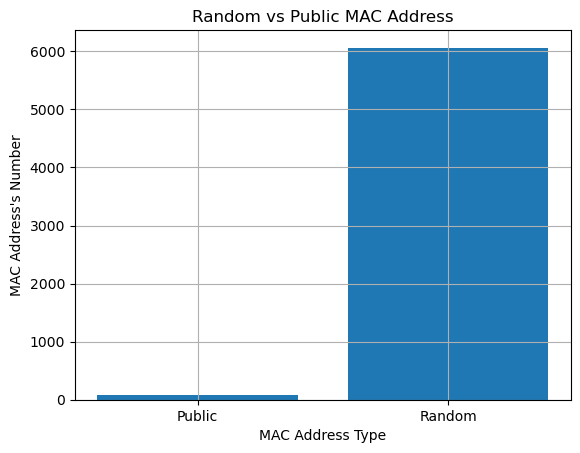

In [565]:
# plotRandomPublicMAC(data)
plotRandomPublicMAC([dataLearning[6]])

Existe una clara victoria para las direcciones MAC aleatorias de todas las tramas recogidas por el ESP32.

Esto podría suponer un problema, aunque existen maneras para intentar minimizar todo lo posible el impacto de este efecto. Uno de ellos es el de seccionar en intervalos de tiempo cortos (en este caso de 5 minutos), de manera que aunque cambie de dirección dentro de ese intervalo, la variación en el total de dispositivos captados será mínimo y lo precisa posible.

## Evolución del número de dispositivos

Con la ayuda de un contador de personas instalado la puerta de la biblioteca, se ha realizado una medición de cuantas personas hay dentro. Podemos representar la evolución de este dato para comprobar si tiene una forma similar a la obtenida con los receptores BLE:

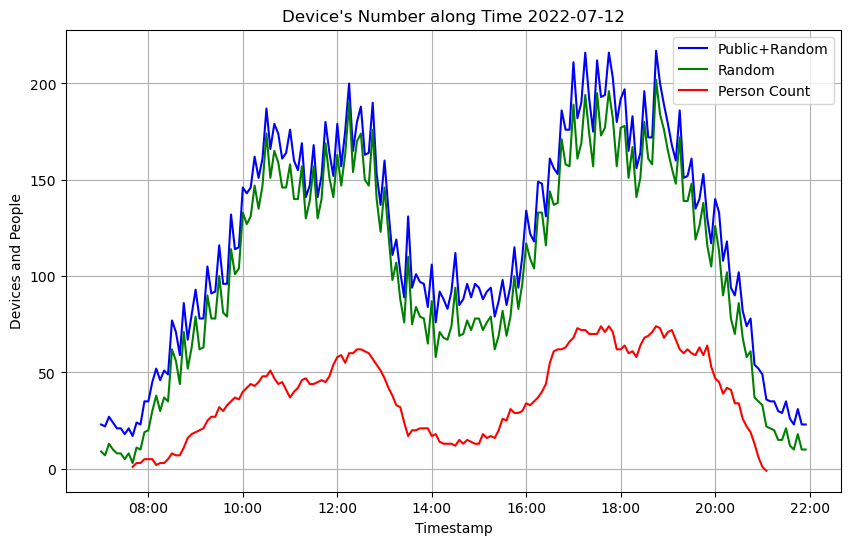

In [566]:
# plotTotalDevices(data, personCount, sampling)
plotTotalDevices([dataLearning[6]], [personCountLearning[6]], sample)

Se puede apreciar claramente que las curvas poseen un parecido bastante interesante. La diferencia de amplitud entre el número de personas (rojo) y el número de dispositivos (azul y verde) se debe a que normalmente una persona cuenta con más de un dispositivo, por ejemplo, un móvil, portátil, auriculares, etc.

Además, podemos cargar los datos de distintos días para así poder comparar la evolución entre distintos días:

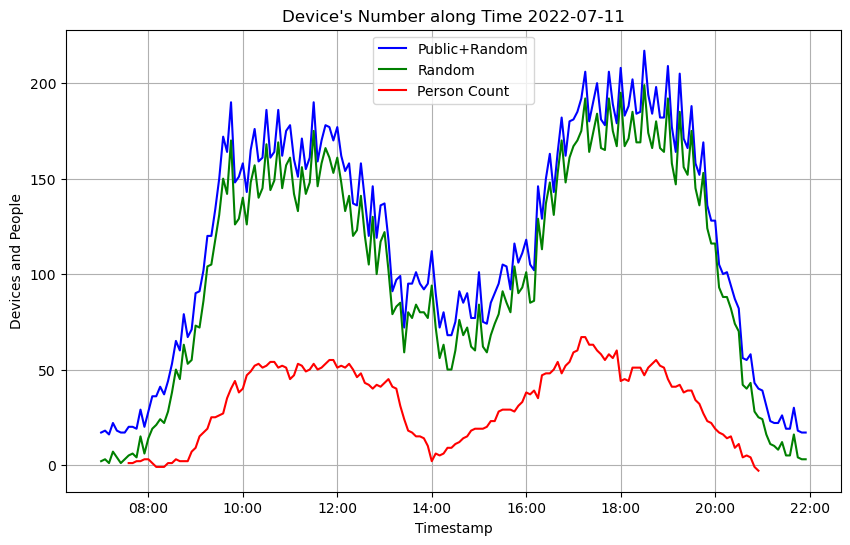

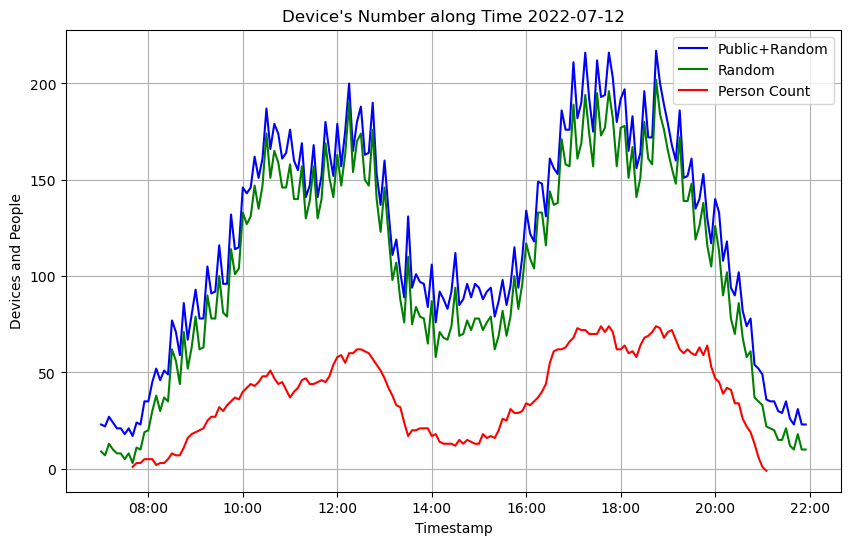

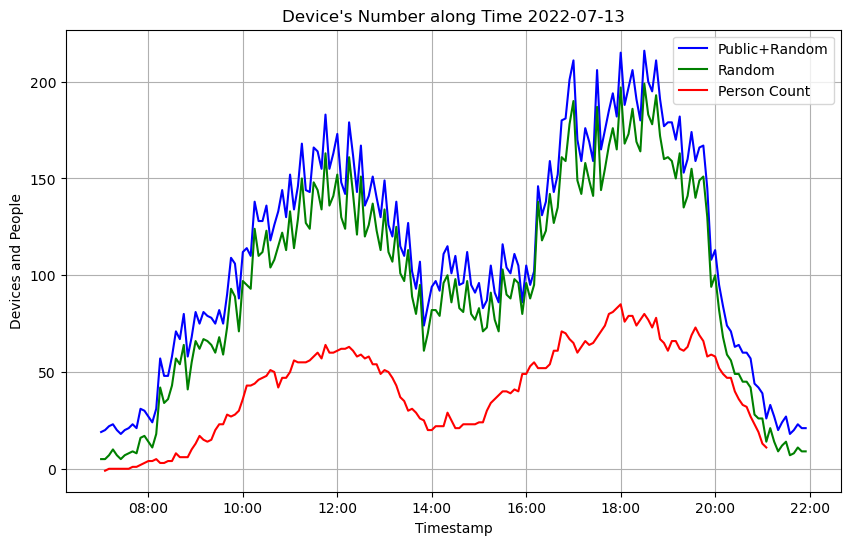

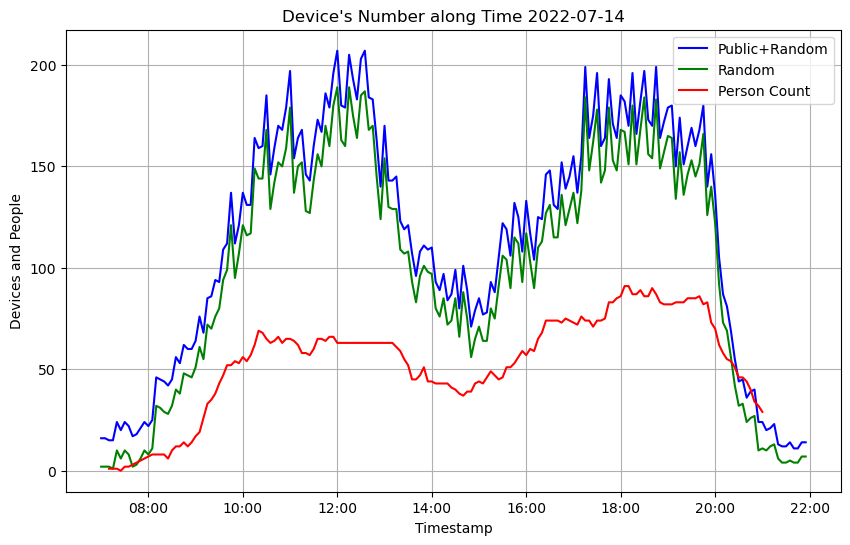

In [567]:
# plotTotalDevices(data, personCount, sampling)
plotTotalDevices(dataLearning[5:9], personCountLearning[5:9], sample)

Como se puede ver, la forma de la gráfica no varía y lo único que varía es la amplitud.

Todas las funciones desarrolladas permiten elegir entre utilizar todo el conjunto de datos o únicamente las direcciones Random, para tener más flexibilidad a la hora de tratar los datos.

Para tener una visión más específica de dónde se concentran los dispositivos, vamos a aprovechar el hecho de tener repartidos los receptores en distintas localizaciones para visualizar la evolución de cada uno de los receptores:

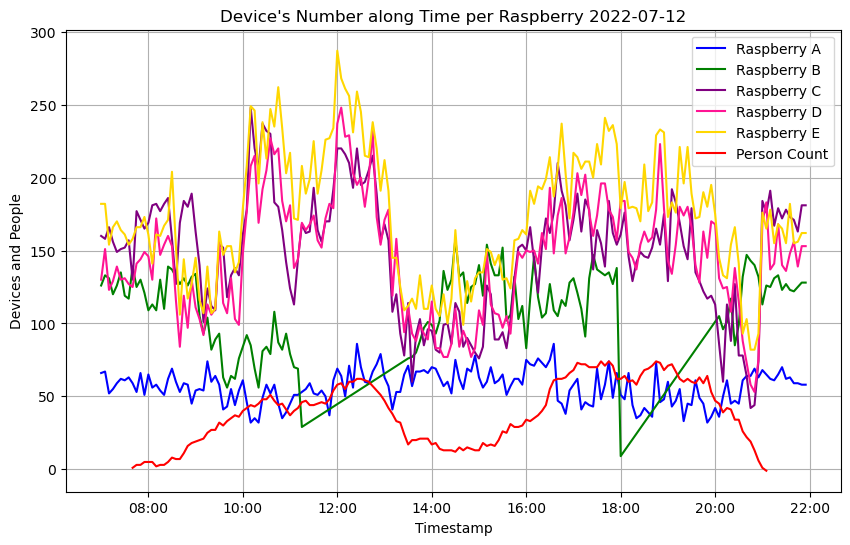

In [568]:
# plotTotalDevicesByRaspberry(data, personCount, state, sampling, initHour=None, endHour=None)
plotTotalDevicesByRaspberry([dataLearning[6]], [personCountLearning[6]], [stateLearning[6]], sample)

Observando el resultado obtenido, vemos que tiene sentido que tanto a tempranas como a altas horas del día (antes de las 08:00 cuando está cerrada y a partir de las 21:00 h cuando la biblioteca cierra) el número de dispositivos capturados decrezca.

Además, los datos tienen dos claros picos de actividad, situados entre las 10:00 h-13:00 h y 16:00 h-19:00 h. Vamos a hacer Zoom a una de las zonas mencionadas:

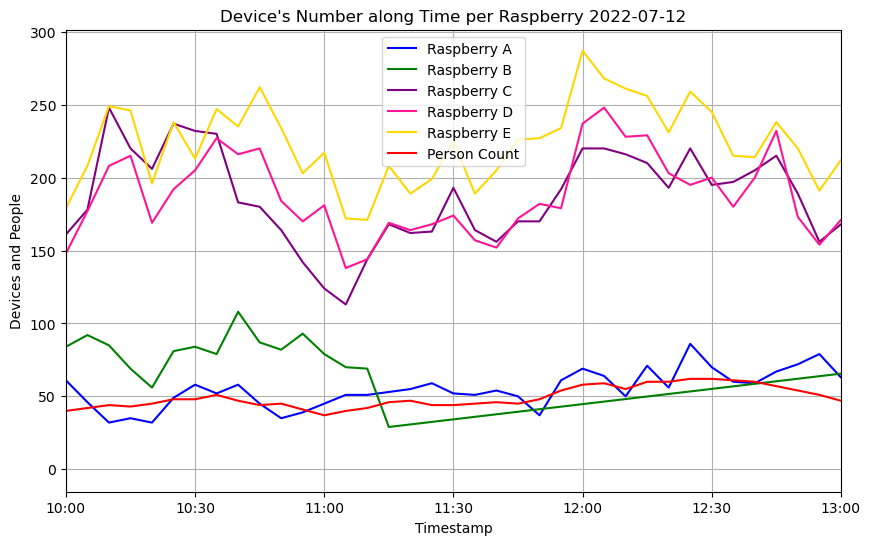

In [569]:
# plotTotalDevicesByRaspberry(data, personCount, state, sampling, initHour=None, endHour=None)
plotTotalDevicesByRaspberry([dataLearning[6]], [personCountLearning[6]], [stateLearning[6]], sample, initHour=10,
                            endHour=13)

## Dispositivos fuera del horario. Cálculo del offset

Los datos muestran que se detectan dispositivos en horas fuera del horario de apertura de la biblioteca, lo que podrían identificarse con personas que pasan por el exterior o dispositivos que ya existen dentro de la biblioteca, lo cuales podríamos eliminar del conjunto. Para ello, vamos a fijarnos en la persistencia de los dispositivos durante un periodo de tiempo fuera del horario. Si un dispositivo se encuentra en todos o casi todos los intervalos de tiempo dentro de ese periodo, podemos asegurar que ese dispositivo está siempre en la zona.

Este estudio se va a hacer entre las 07:00:00 de la mañana y las 07:30:00, además de entre las 21:30:00 y las 22:00:00.
Estas horas son modificables:

In [570]:
# devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour = devicesOffset(data, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True)
devicesOffset([dataLearning[6]])

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 16
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 22



([28:de:65:1d:6f:fa    7
  28:de:65:1d:6f:f9    7
  c6:d1:f4:e8:fa:1a    7
  28:de:65:5f:be:d2    7
  28:de:65:43:68:e0    7
  28:de:65:43:68:78    7
  28:de:65:43:66:dc    7
  c2:ce:06:f1:94:c4    7
  28:de:65:17:e6:6d    7
  28:de:65:1d:6f:eb    7
  28:de:65:1d:6f:dc    7
  28:de:65:1d:6f:d8    7
  28:de:65:1d:6f:d7    7
  28:de:65:1d:6f:ce    7
  28:de:65:17:e6:c6    7
  54:15:e6:7c:5d:23    5
  Name: MAC, dtype: int64],
 [16],
 [28:de:65:17:e6:6d    5
  28:de:65:1d:6f:fa    5
  28:de:65:17:e6:c6    5
  c6:d1:f4:e8:fa:1a    5
  28:de:65:43:68:f8    5
  28:de:65:43:68:e0    5
  28:de:65:43:66:dc    5
  28:de:65:43:68:78    5
  28:de:65:1d:6f:f9    5
  28:de:65:1d:6f:eb    5
  28:de:65:1d:6f:dc    5
  28:de:65:1d:6f:d8    5
  28:de:65:1d:6f:d7    5
  28:de:65:1d:6f:ce    5
  5a:49:ce:f7:ee:6c    4
  e0:4a:49:7b:21:ac    4
  c8:e1:d2:ad:aa:c6    4
  7d:0e:a2:aa:3c:24    4
  70:72:f3:47:e4:4d    4
  66:19:27:35:d1:c8    4
  ff:07:85:e9:6e:2a    4
  58:34:63:9a:8a:6d    4
  Name: MAC, dt

Como se puede ver, estos resultados los obtenemos para un martes y usamos un intervalo de media hora, 30 minutos. Podríamos ampliar el experimento usando más días para comprobar si el número de dispositivos es parecido, además de variar el intervalo de muestreo:

In [571]:
# devicesFirstHourDataframe, devicesFirstHour, devicesSecondHourDataframe, devicesSecondHour = devicesOffset(data, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True)
devicesOffset(dataLearning[5:9])

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-11: 14
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-11: 15

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 16
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 22

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-13: 14
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-13: 15

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-14: 15
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-14: 10



([28:de:65:17:e6:6d    7
  28:de:65:1d:6f:fa    7
  28:de:65:17:e6:c6    7
  28:de:65:5f:be:d2    7
  28:de:65:43:68:e0    7
  28:de:65:43:68:78    7
  28:de:65:43:66:dc    7
  68:72:c3:96:c8:2f    7
  28:de:65:1d:6f:f9    7
  28:de:65:1d:6f:dc    7
  28:de:65:1d:6f:d8    7
  28:de:65:1d:6f:d7    7
  28:de:65:1d:6f:ce    7
  28:de:65:1d:6f:eb    7
  Name: MAC, dtype: int64,
  28:de:65:1d:6f:fa    7
  28:de:65:1d:6f:f9    7
  c6:d1:f4:e8:fa:1a    7
  28:de:65:5f:be:d2    7
  28:de:65:43:68:e0    7
  28:de:65:43:68:78    7
  28:de:65:43:66:dc    7
  c2:ce:06:f1:94:c4    7
  28:de:65:17:e6:6d    7
  28:de:65:1d:6f:eb    7
  28:de:65:1d:6f:dc    7
  28:de:65:1d:6f:d8    7
  28:de:65:1d:6f:d7    7
  28:de:65:1d:6f:ce    7
  28:de:65:17:e6:c6    7
  54:15:e6:7c:5d:23    5
  Name: MAC, dtype: int64,
  28:de:65:17:e6:6d    7
  28:de:65:1d:6f:f9    7
  28:de:65:17:e6:c6    7
  c6:d1:f4:e8:fa:1a    7
  28:de:65:43:68:e0    7
  28:de:65:43:66:dc    7
  28:de:65:1d:6f:fa    7
  28:de:65:43:68:78  

Basándonos en estos cuatro días, vemos que los resultados son bastante parecidos, con una media de dos dispositivos por la mañana y uno por la noche. Aun así, para que este experimento sea más confiable, deber probarse en un día donde la biblioteca permanezca cerrada por completo, por ejemplo, un sábado o domingo. Si los resultados son similares en un día como este, podemos confirmar que esos dispositivos se encuentran siempre en el entorno y no corresponden a personas.

In [572]:
# devicesFirstHourDataframeList, nDevicesFirstHourList, devicesSecondHourDataframeList, nDevicesSecondHourList = devicesOffset(data, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True)
dataWeekend, _, _ = readAndPrepareDataFromDirectory("../data/ble_weekend", "../data/personcount_weekend", sample)
devicesOffset(dataWeekend)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-16: 13
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-16: 13



([28:de:65:17:e6:6d    7
  28:de:65:1d:6f:fa    7
  c6:d1:f4:e8:fa:1a    7
  28:de:65:17:e6:c6    7
  28:de:65:43:68:e0    7
  28:de:65:43:68:78    7
  28:de:65:43:66:dc    7
  68:72:c3:96:c8:2f    7
  28:de:65:1d:6f:f9    7
  28:de:65:1d:6f:dc    7
  28:de:65:1d:6f:d8    7
  28:de:65:1d:6f:d7    7
  28:de:65:1d:6f:ce    7
  Name: MAC, dtype: int64],
 [13],
 [28:de:65:17:e6:6d    5
  28:de:65:1d:6f:f9    5
  c6:d1:f4:e8:fa:1a    5
  28:de:65:43:68:e0    5
  28:de:65:43:68:78    5
  28:de:65:1d:6f:fa    5
  28:de:65:43:66:dc    5
  28:de:65:1d:6f:eb    5
  28:de:65:1d:6f:dc    5
  28:de:65:1d:6f:d8    5
  28:de:65:1d:6f:d7    5
  28:de:65:1d:6f:ce    5
  28:de:65:17:e6:c6    5
  Name: MAC, dtype: int64],
 [13])

Efectivamente, obtenemos resultados similares que para los días de la semana, lo cual confirma que existen dispositivos que se encuentran siempre en la biblioteca funcionando fuera del horario, lo que nos permite eliminarlos.

## Cálculo del error y ratio dispositivos/personas

A priori la única manera que tenemos de comparar días entre sí es representándolos gráficamente y observandolos.
Para solucionar esto, podemos calcular el error que existe entre el número de dispositivos captados por los receptores y el número de personas contabilizadas por el sensor en la entrada. Esto no dará un valor con el que podremos medir y comparar entre distintos días.


In [573]:
# metrics = errorCalc(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True)
errorCalc(dataLearning, personCountLearning, sample)

El error medio del día es: 87.694
El error cuadrático medio del día es: 8184.235
La varianza del error del día es: 494.0
El error medio del día es: 99.847
El error cuadrático medio del día es: 10974.624
La varianza del error del día es: 1005.0
El error medio del día es: 122.63
El error cuadrático medio del día es: 16179.045
La varianza del error del día es: 1141.0
El error medio del día es: 111.803
El error cuadrático medio del día es: 13979.242
La varianza del error del día es: 1479.0
El error medio del día es: 103.115
El error cuadrático medio del día es: 12134.745
La varianza del error del día es: 1502.0
El error medio del día es: 98.41
El error cuadrático medio del día es: 10706.436
La varianza del error del día es: 1022.0
El error medio del día es: 91.847
El error cuadrático medio del día es: 9160.548
La varianza del error del día es: 725.0
El error medio del día es: 80.057
El error cuadrático medio del día es: 7199.369
La varianza del error del día es: 790.0
El error medio del dí

Error  Quadratic Error  Variance
Date                                          
2022-07-01   87.694         8184.235     494.0
2022-07-04   99.847        10974.624    1005.0
2022-07-05  122.630        16179.045    1141.0
2022-07-06  111.803        13979.242    1479.0
2022-07-07  103.115        12134.745    1502.0
2022-07-11   98.410        10706.436    1022.0
2022-07-12   91.847         9160.548     725.0
2022-07-13   80.057         7199.369     790.0
2022-07-14   71.567         6209.376    1088.0
2022-07-15   63.172         4491.376     501.0
2022-07-19   73.212         5694.129     334.0
2022-07-20   50.344         2808.433     274.0

Una vez que ya podemos tener estas tres medidas para cualquier día, es hora de comparar distintos días y ver un resumen para cada uno de ellos.
Para ello, ejecutamos una primera función que lee todos los archivos en un directorio y los prepara para posteriormente, hacer los calculos recogiendolos en una tabla para que pueda verse más sencillamente.

In [574]:
# metrics = errorCalc(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True)
errorCalc(dataLearning[5:9], personCountLearning[5:9], sample, show=False)

Error  Quadratic Error  Variance
Date                                         
2022-07-11  98.410        10706.436    1022.0
2022-07-12  91.847         9160.548     725.0
2022-07-13  80.057         7199.369     790.0
2022-07-14  71.567         6209.376    1088.0

El error lo calculamos como la diferencia entre el número de dispositivos dado por los receptores y el número de personas contadas por el sensor de la entrada en cada intervalo de tiempo. Esto puede indicar que a mayor error, los usuarios deben ir provistos de más dispositivos cada uno o se está produciendo un error a la hora de contabilizar dispositivos, añadiendo dispositivos temporales o no están en el interior de la biblioteca.

Para apoyar esta métrica, puede ser interesante obtener la relación entre el número de dispositivos y el número de personas, para así poder obtener una estimación de cuantos dispositivos porta cada usuario.

In [575]:
# ratioDataframe, ratio = deviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True, offset=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70)
deviceRatio([dataLearning[6]], [personCountLearning[6]], sample)

El ratio medio para el día 2022-07-12 es: 4.48


([                     Ratio
  Timestamp                 
  2022-07-12 08:00:00    7.0
  2022-07-12 08:05:00    9.0
  2022-07-12 08:10:00   26.0
  2022-07-12 08:15:00  15.33
  2022-07-12 08:20:00   17.0
  ...                    ...
  2022-07-12 20:40:00   3.36
  2022-07-12 20:45:00   4.11
  2022-07-12 20:50:00   4.15
  2022-07-12 20:55:00   8.67
  2022-07-12 21:00:00   49.0
  
  [157 rows x 1 columns]],
             Ratio
 Date             
 2022-07-12   4.48)

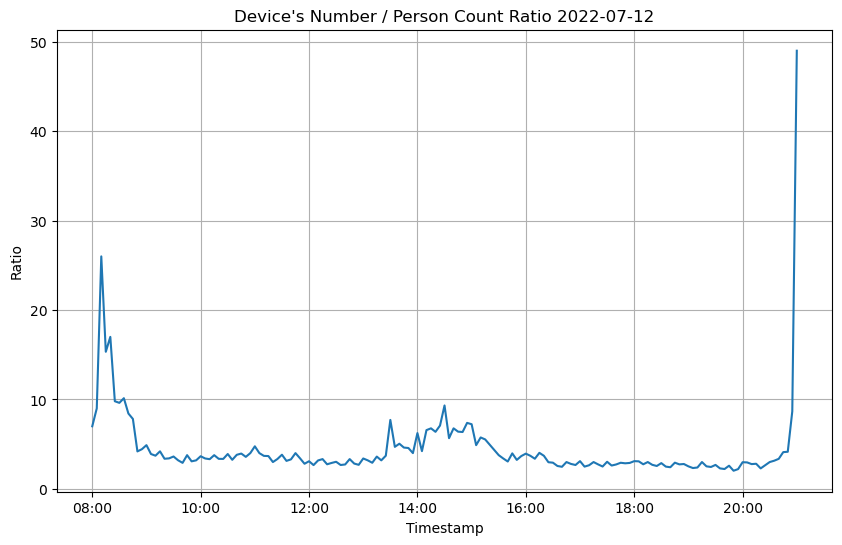

In [576]:
# plotDeviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, offset=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False)
plotDeviceRatio([dataLearning[6]], [personCountLearning[6]], sample)

Como se puede ver, hay un gran pico a primera hora de la mañana y se estabiliza a lo largo del día. Vamos a representar diferentes días para comparar esta evolución:

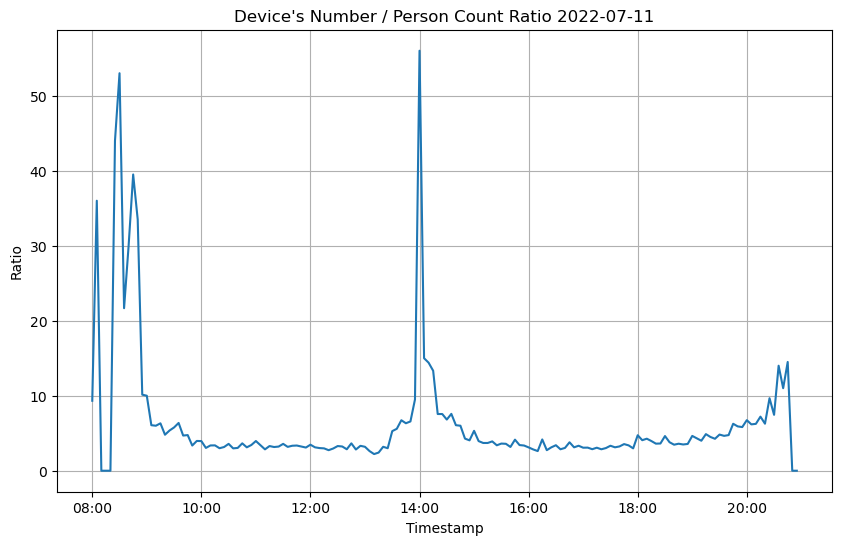

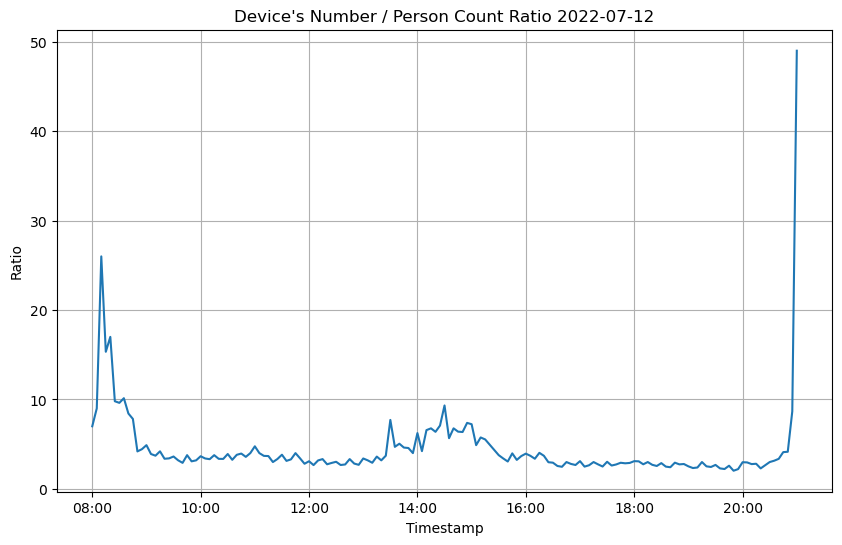

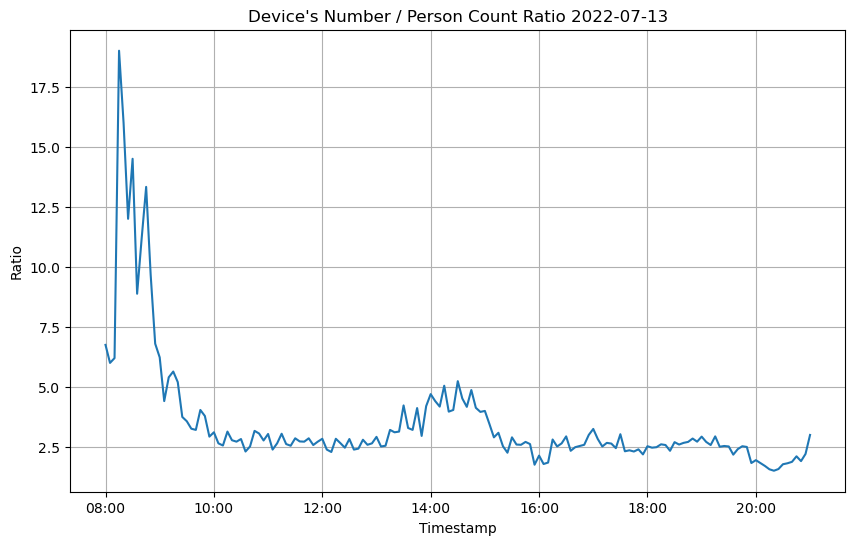

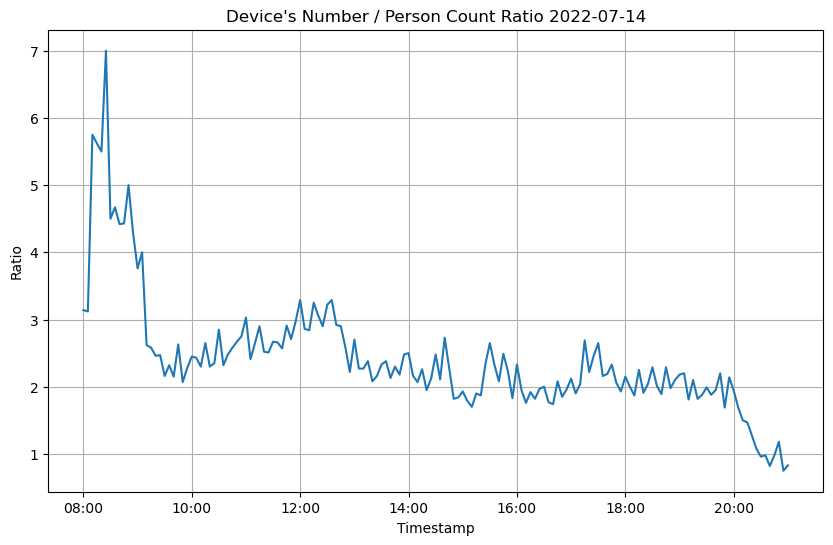

In [577]:
# plotDeviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, offset=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False)
plotDeviceRatio(dataLearning[5:9], personCountLearning[5:9], sample)

Vemos que tienen sus diferencias, pero aproximadamente tienen bastantes semejanzas.
El primer pico es debido a que los receptores estám capurando algún mensaje dado por algún dispositivo temporal o que simplemente está de paso; sin embargo, nadie ha entrado a la biblioteca, por lo que el ratio aumenta.

Anteriormente, se ha planteado la opción de que existan dispositivos ya establecidos en la biblioteca fuera del horario de apertura que estén generando continuamente mensajes, los cuales podríamos suprimir. Vamos a representar ahora el ratio teniendo esto en cuenta:

El ratio medio para el día 2022-07-12 es: 3.53


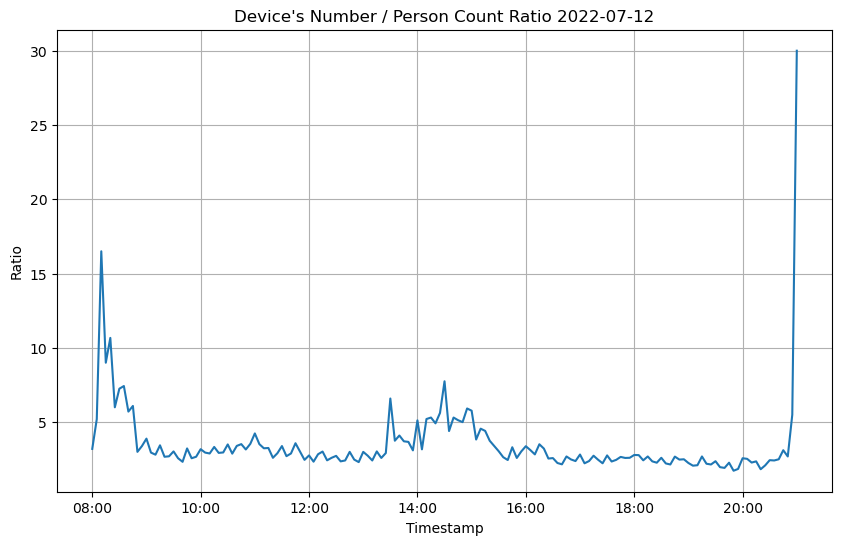

In [578]:
# ratioDataframe, ratio = deviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=True, offset=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70)
ratioDf, _ = deviceRatio([dataLearning[6]], [personCountLearning[6]], sample, offset=True)
# plotDeviceRatio(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, offset=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, showDetail=False)
plotDeviceRatio([dataLearning[6]], [personCountLearning[6]], sample, offset=True)

Como también se ha visto antes, son muy pocos los dispositivos que asignamos a esta categoría, por lo que la diferencia es minúscula.
Por último, vemos que las zonas donde más personas hay, el ratio tiende a ser inferior que las franjas de tiempo donde el número de personas es menor. Esto lo podemos representar con una nube de puntos para visualizar el ratio en funcion del número de personas.

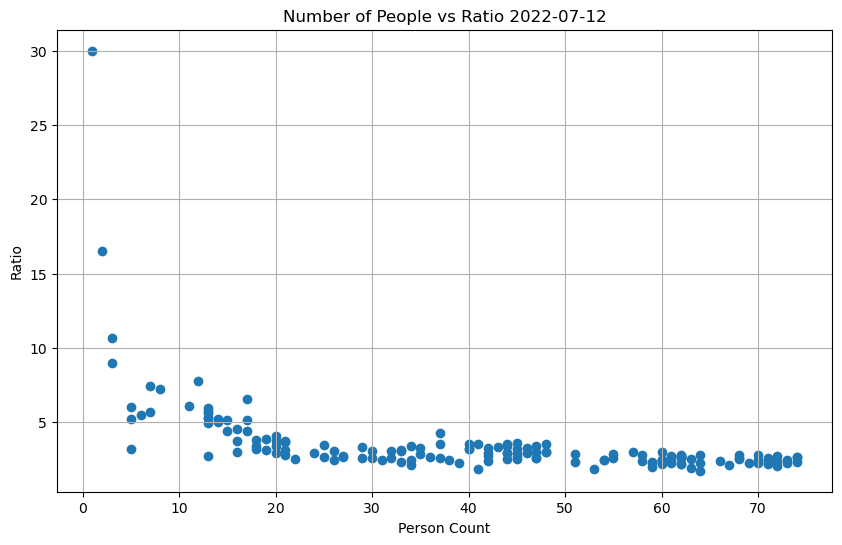

In [579]:
# plotPersonCountRatio(personCount, ratioDataframe)
plotPersonCountRatio([personCountLearning[6]], ratioDf)

## Comparativa entre días de estudio

Disponemos de 15 días en los que se han generado datos tanto de paquetes BLE como del sensor colocado a la entrada de la biblioteca. Sin embargo, algunos días algún receptor ha fallado y los datos están incompletos, por lo que no son del todo fiables.
Para intentar comparar todos los días, se van a calcular el error medio, ratio medio y offset medio.


In [580]:
# tableMetrics = tableMetricList(data, personCount, sampling, startHour="8:00:00", finalHour="21:00:00", show=False, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, offset=False, showDetail=False)
tableMetricList(dataLearning, personCountLearning, sample)

           Start Hour  End Hour    Error Ratio Offset
Date                                                 
2022-07-01    8:00:00  21:00:00   87.694  5.52   10.0
2022-07-04    8:00:00  21:00:00   99.847  3.73   13.0
2022-07-05    8:00:00  21:00:00   122.63  4.45   15.0
2022-07-06    8:00:00  21:00:00  111.803  4.48   16.0
2022-07-07    8:00:00  21:00:00  103.115  3.25   14.0
2022-07-11    8:00:00  21:00:00    98.41   6.3   14.0
2022-07-12    8:00:00  21:00:00   91.847  4.48   19.0
2022-07-13    8:00:00  21:00:00   80.057  3.52   14.0
2022-07-14    8:00:00  21:00:00   71.567  2.42   12.0
2022-07-15    8:00:00  21:00:00   63.172  3.69   11.0
2022-07-19    8:00:00  21:00:00   73.212   6.7   16.0
2022-07-20    8:00:00  21:00:00   50.344  5.48   13.0


Start Hour  End Hour    Error Ratio Offset
Date                                                 
2022-07-01    8:00:00  21:00:00   87.694  5.52   10.0
2022-07-04    8:00:00  21:00:00   99.847  3.73   13.0
2022-07-05    8:00:00  21:00:00   122.63  4.45   15.0
2022-07-06    8:00:00  21:00:00  111.803  4.48   16.0
2022-07-07    8:00:00  21:00:00  103.115  3.25   14.0
2022-07-11    8:00:00  21:00:00    98.41   6.3   14.0
2022-07-12    8:00:00  21:00:00   91.847  4.48   19.0
2022-07-13    8:00:00  21:00:00   80.057  3.52   14.0
2022-07-14    8:00:00  21:00:00   71.567  2.42   12.0
2022-07-15    8:00:00  21:00:00   63.172  3.69   11.0
2022-07-19    8:00:00  21:00:00   73.212   6.7   16.0
2022-07-20    8:00:00  21:00:00   50.344  5.48   13.0

Además, sería de gran utilidad representar los datos para cada día, de distintas maneras para tener también una comparativa visual. Estas gráficas serán:
- Estimación global / Nº real persona vs. Hora intervalo
- Ratio intervalo vs. Hora intervalo
- Nube puntos ratio sobreestimación vs. Nº personas

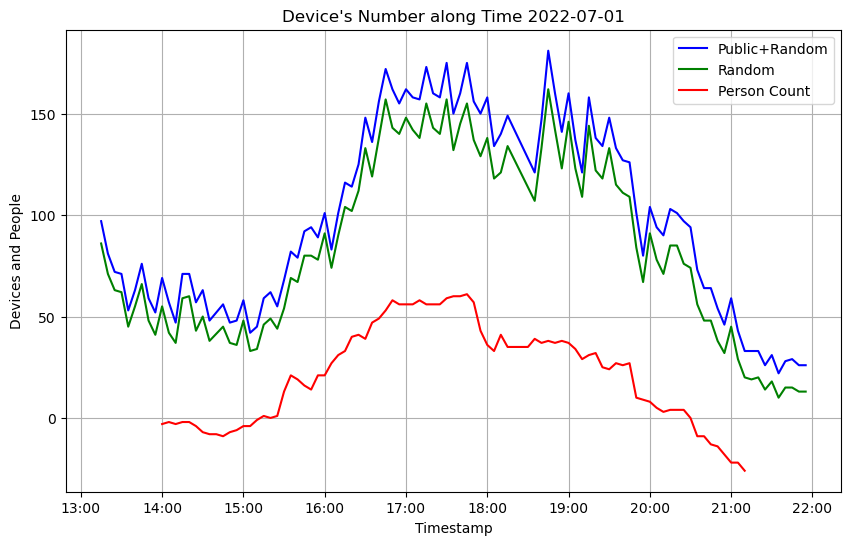

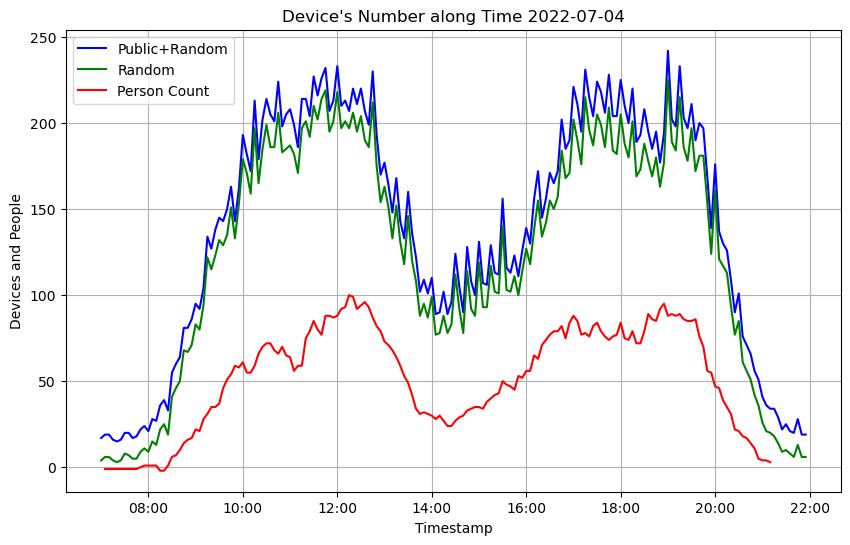

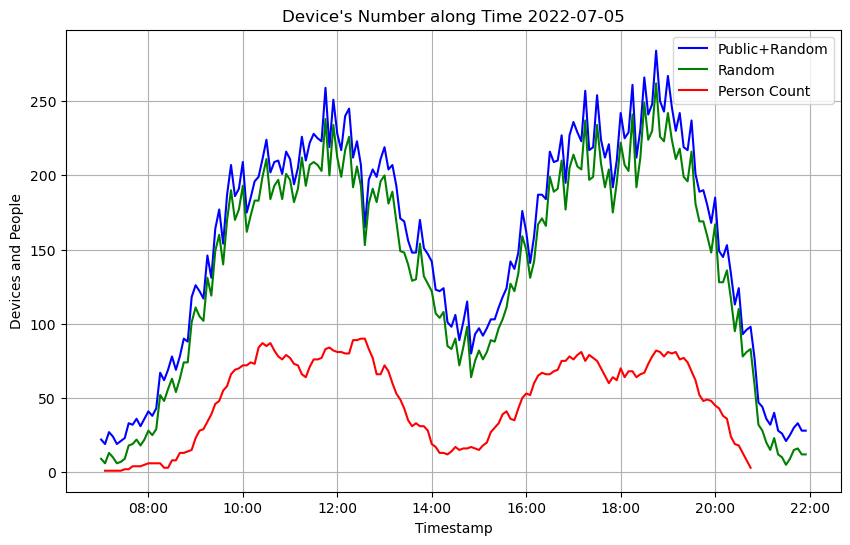

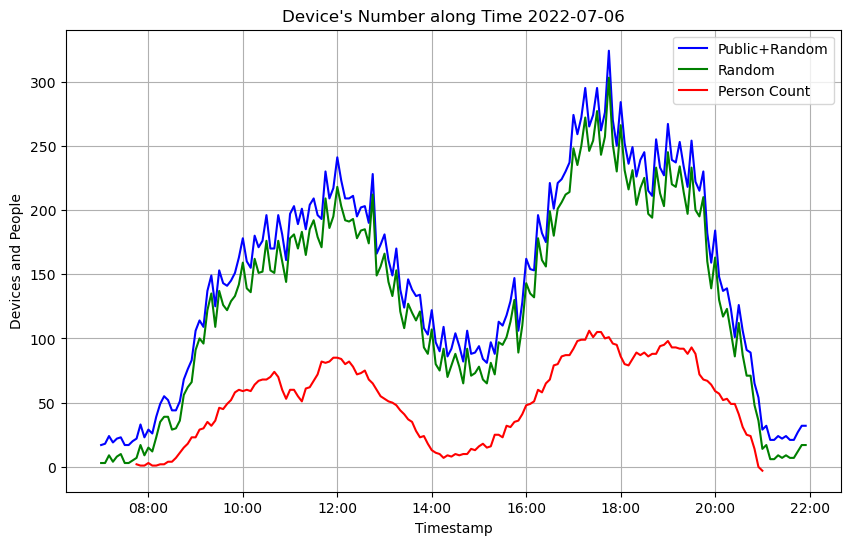

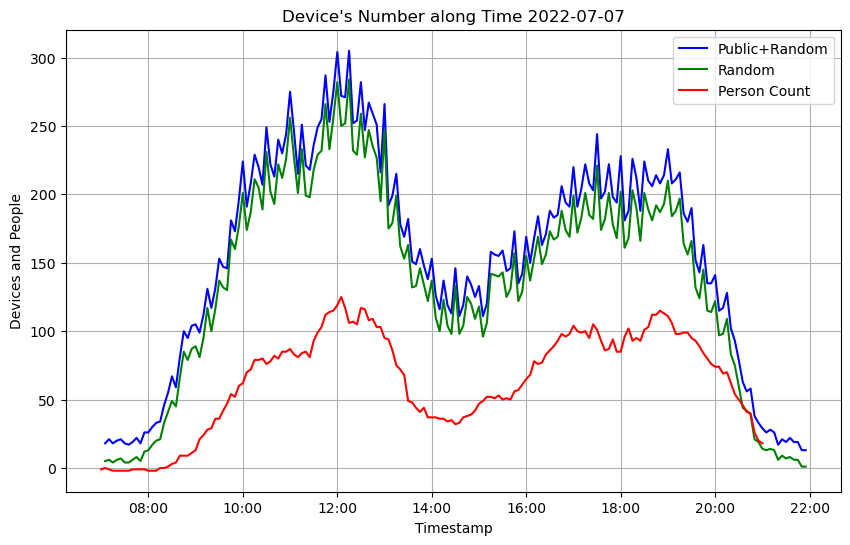

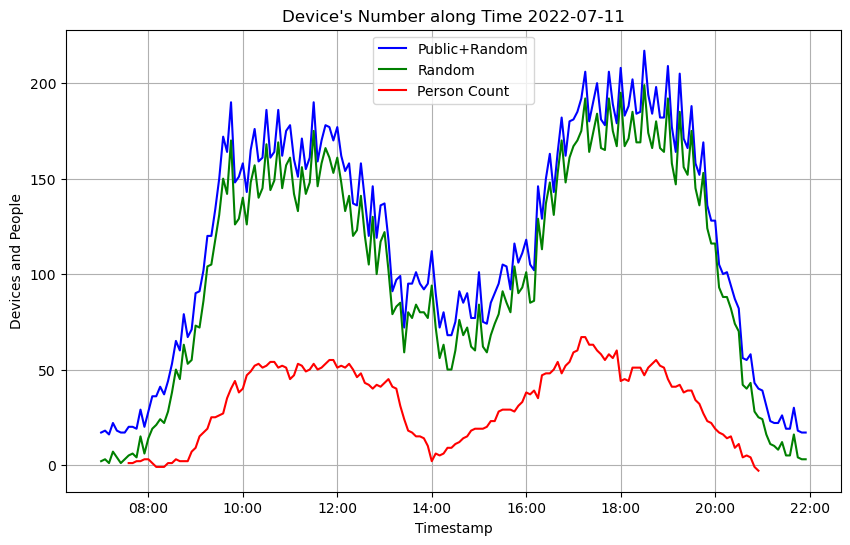

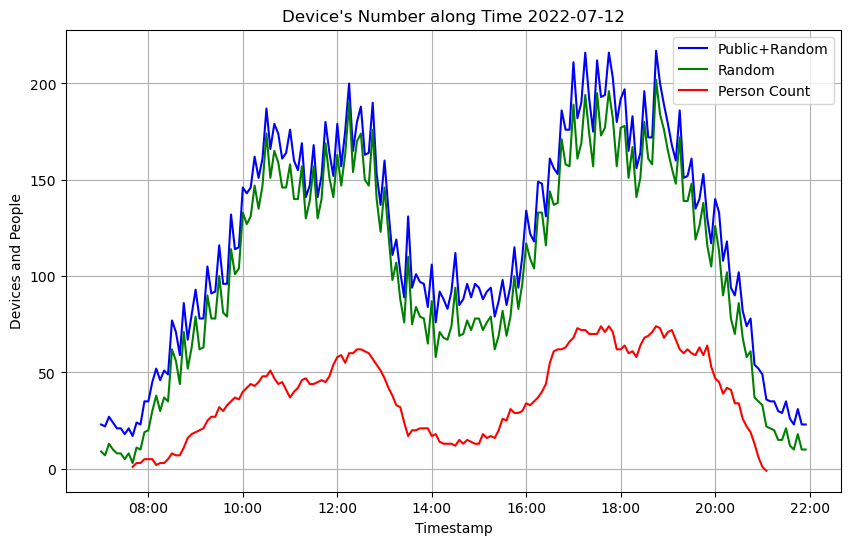

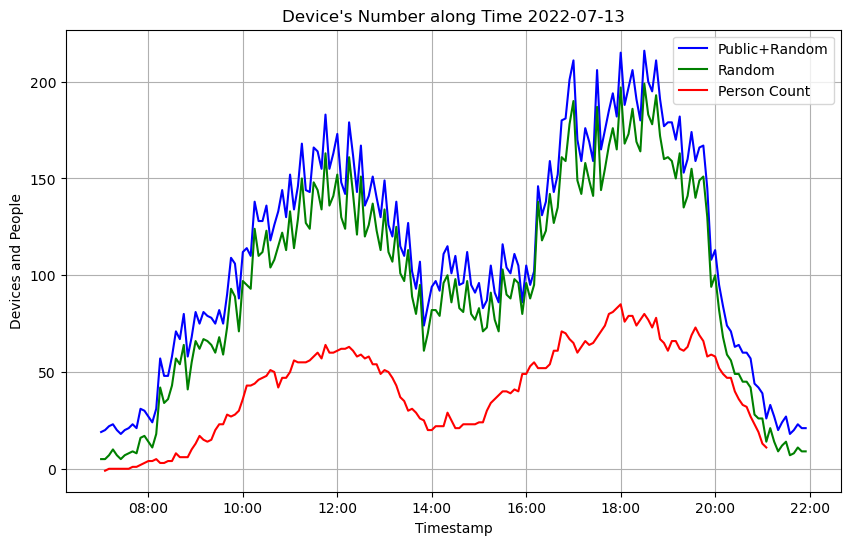

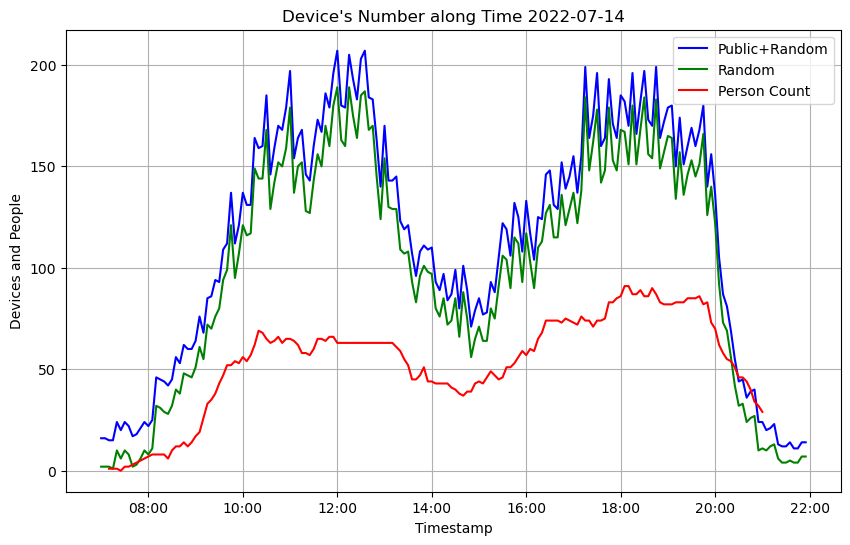

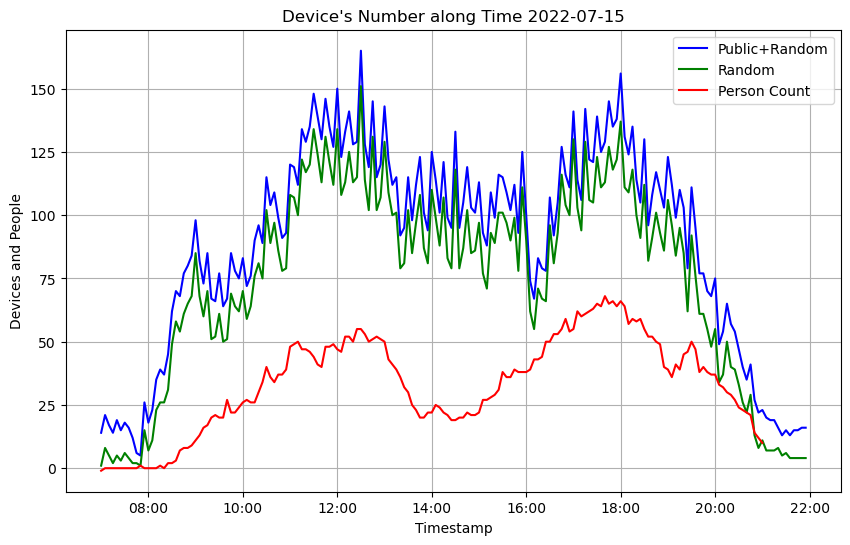

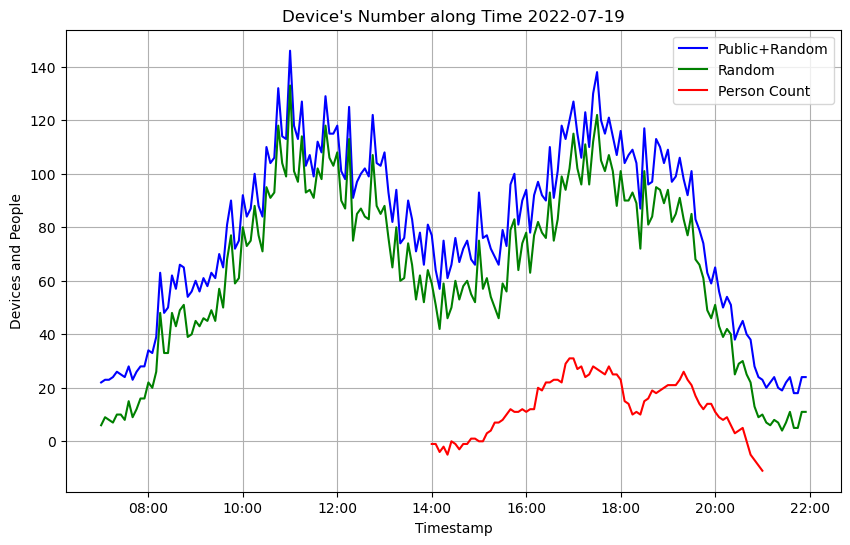

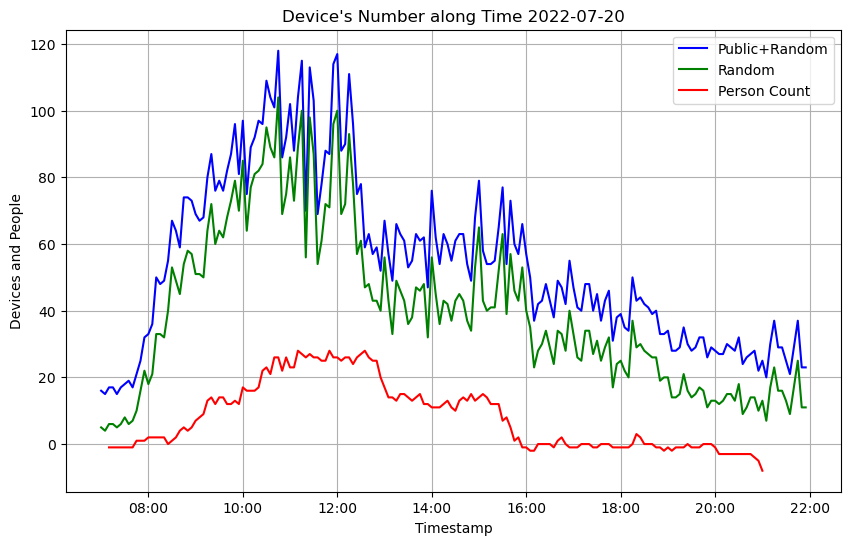

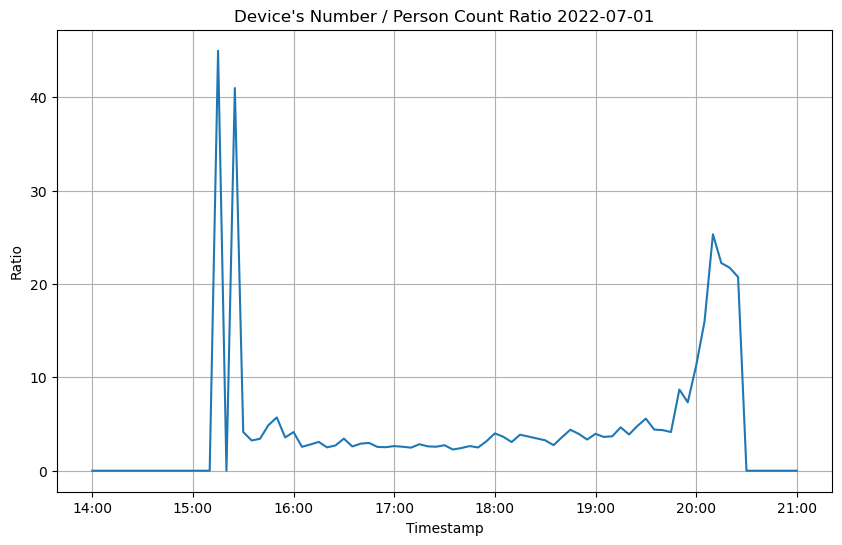

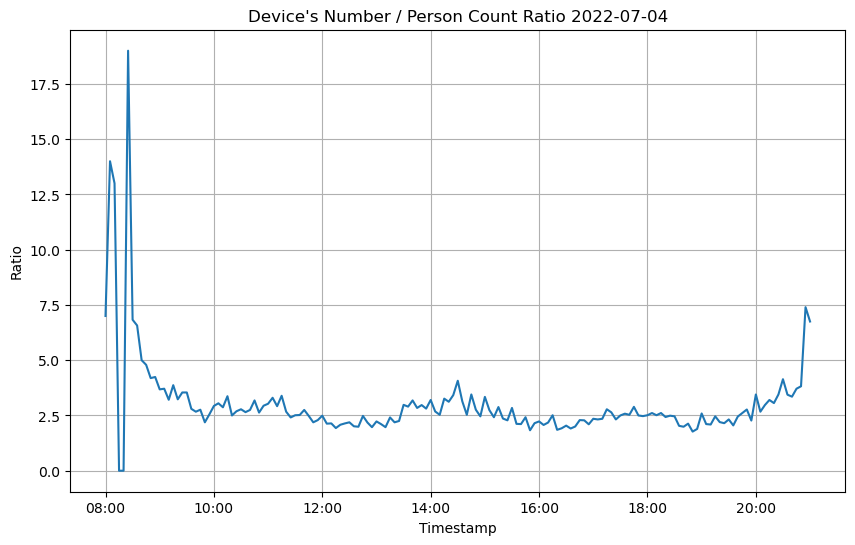

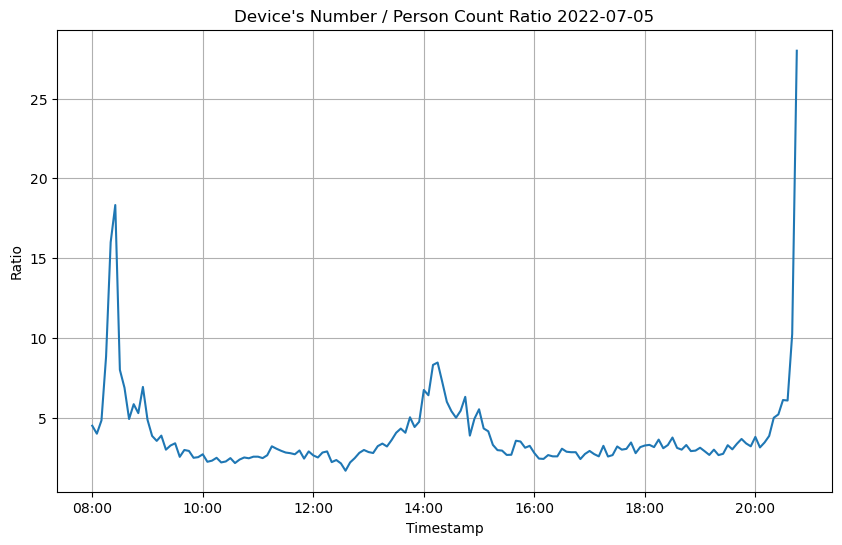

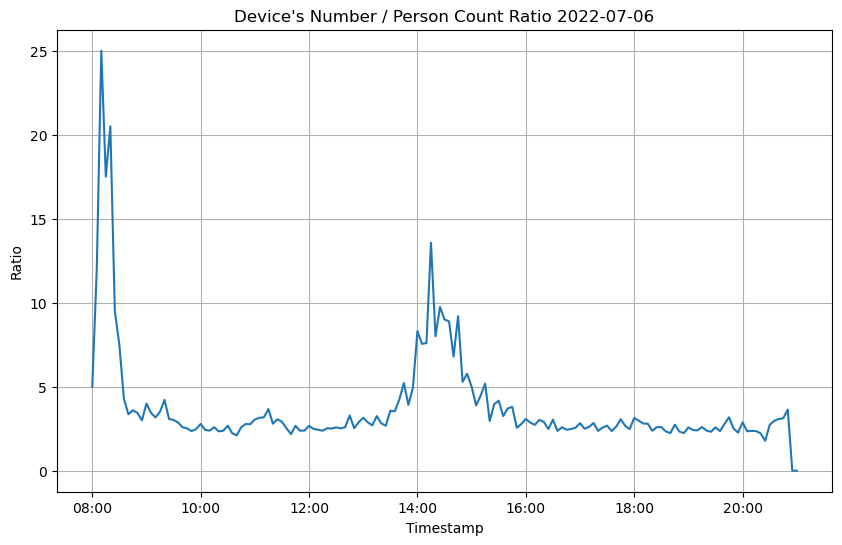

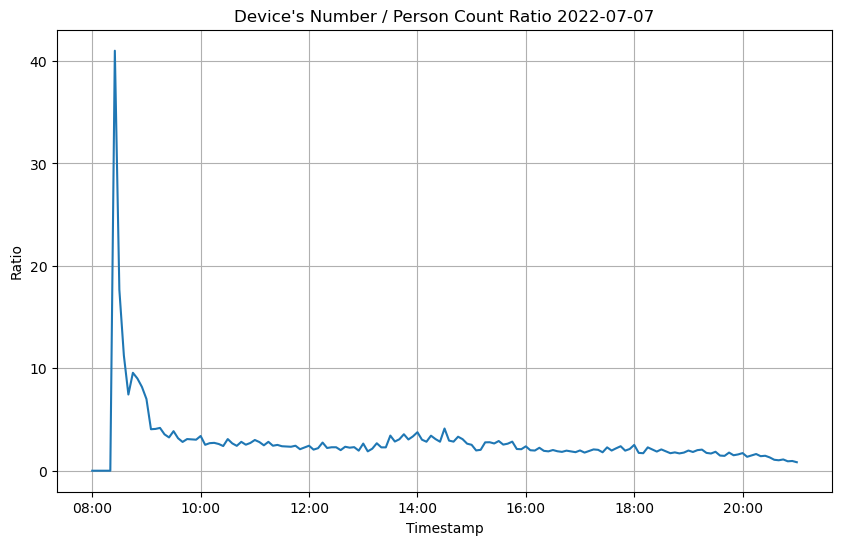

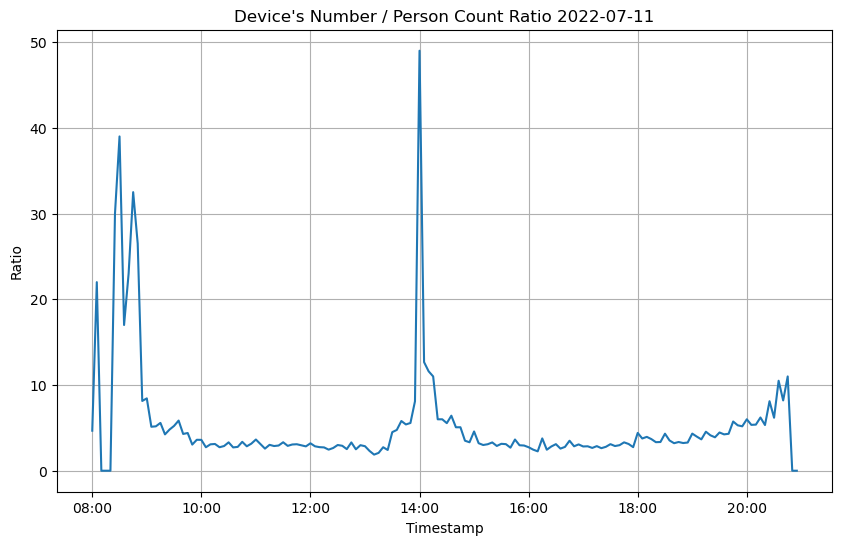

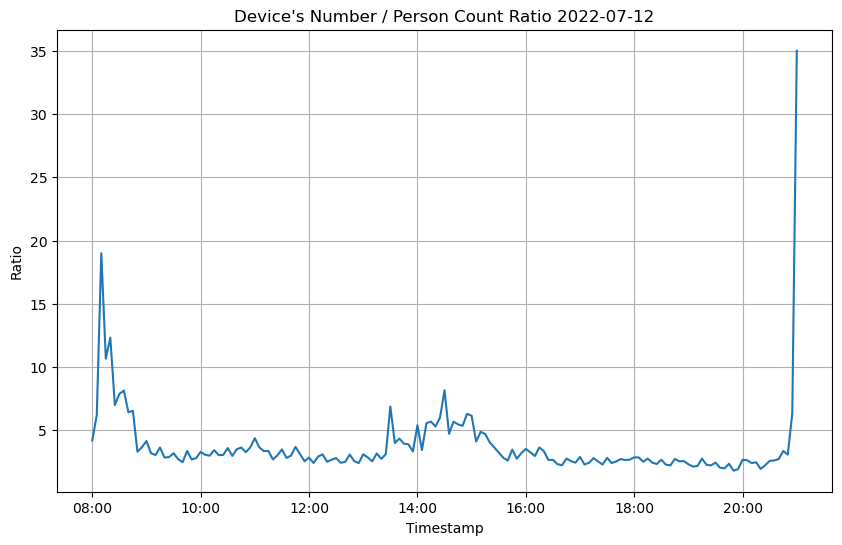

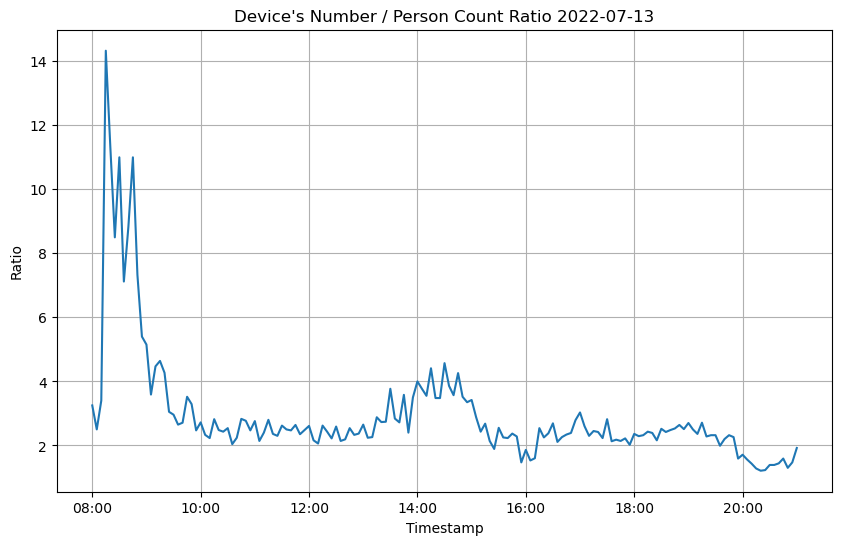

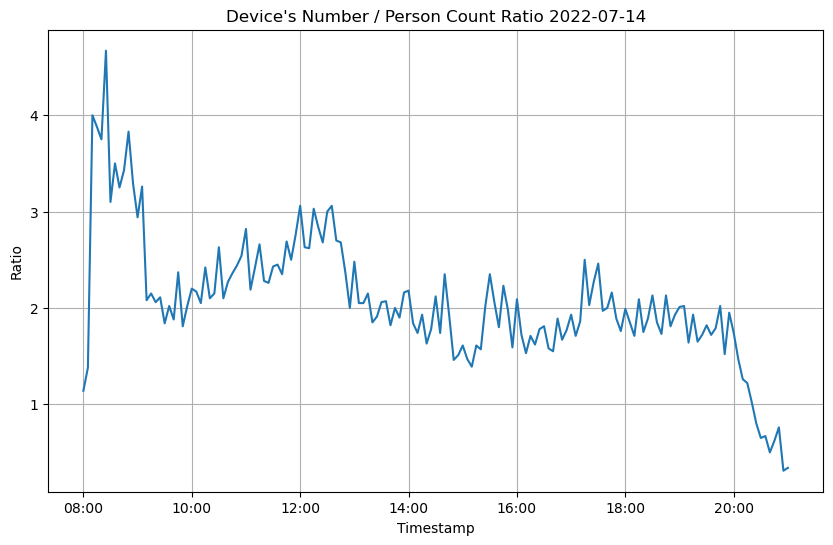

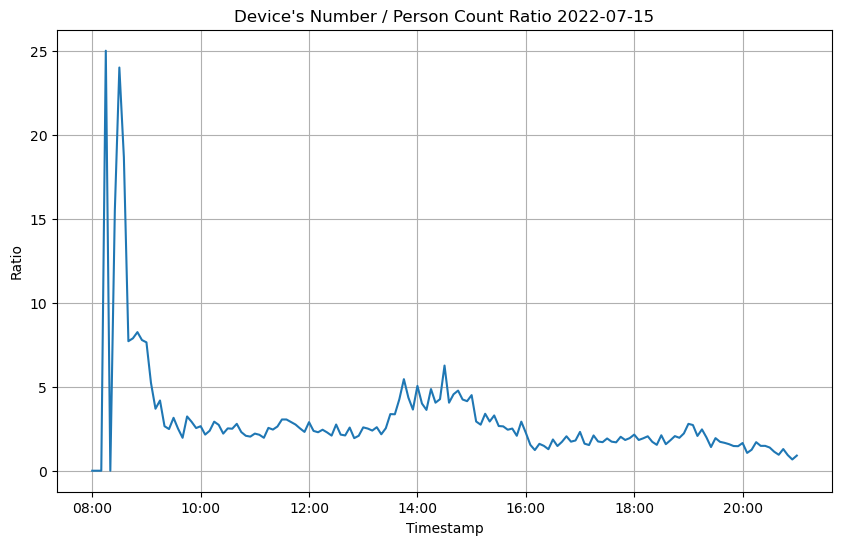

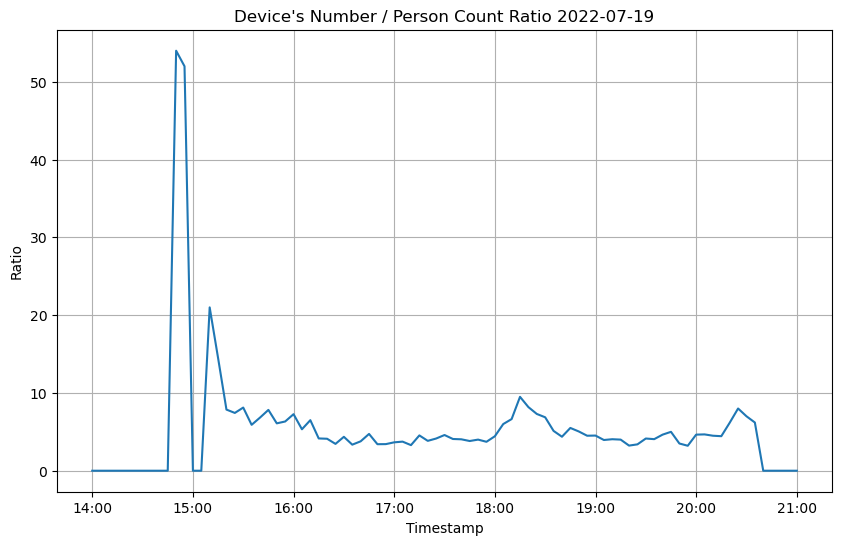

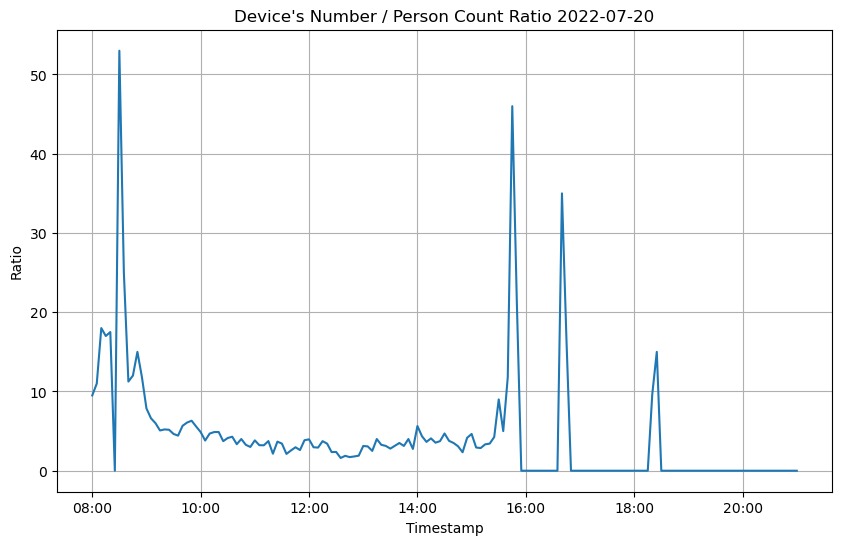

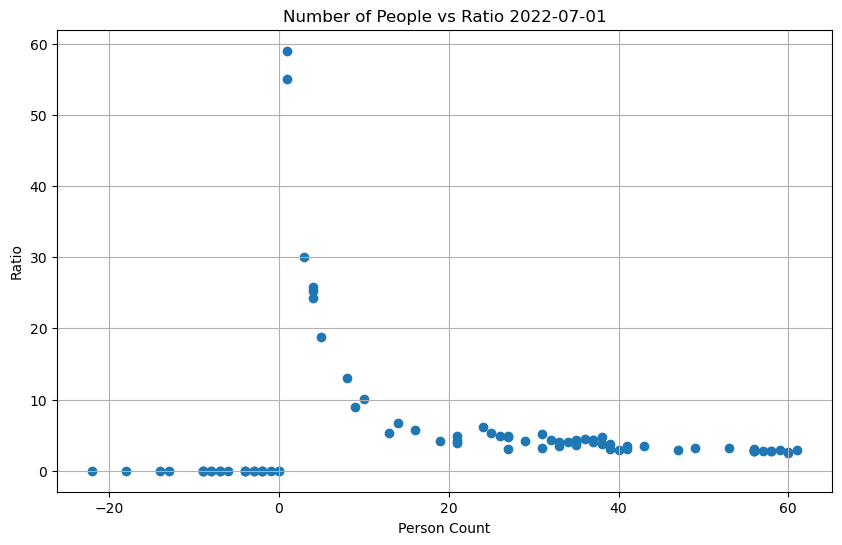

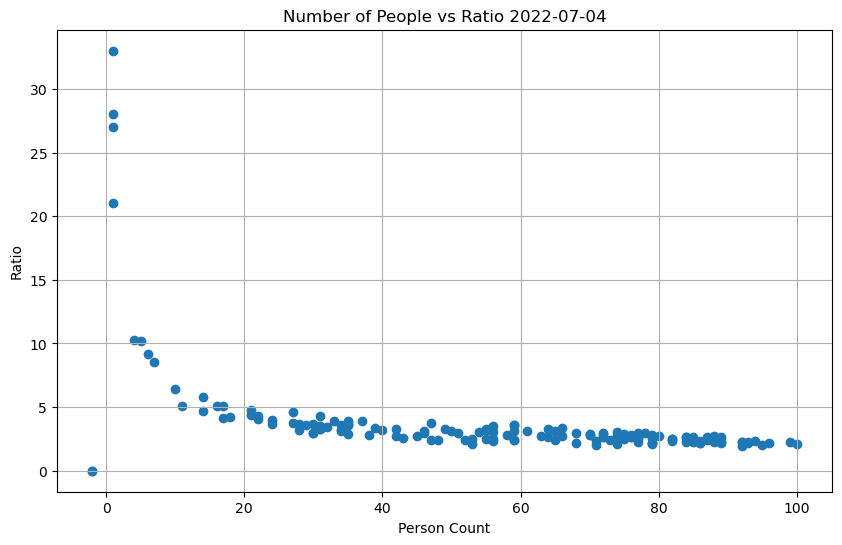

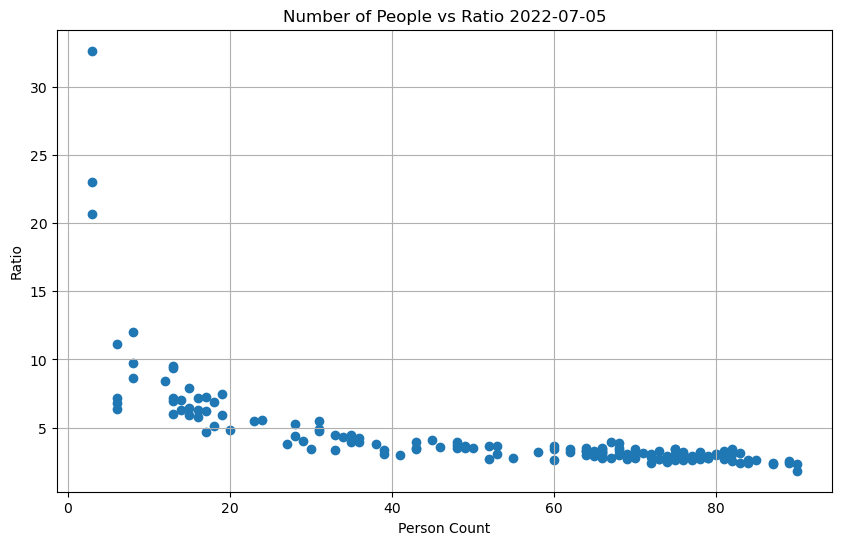

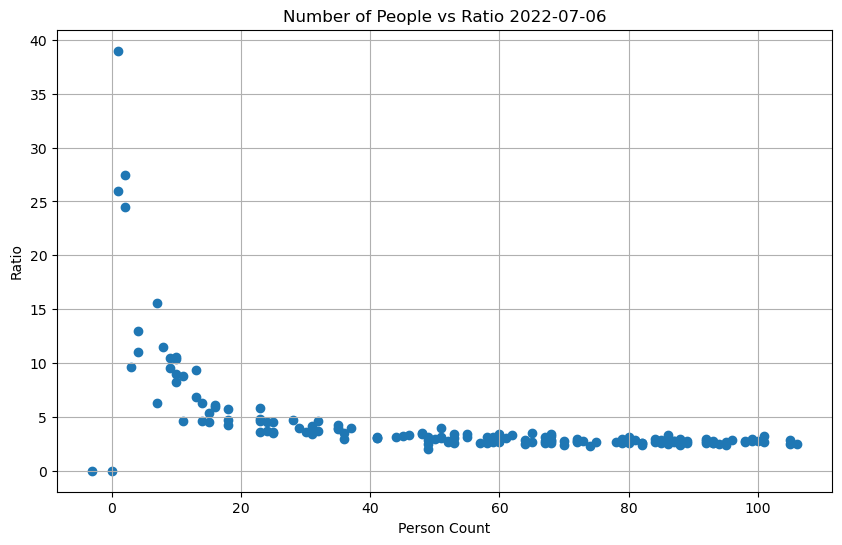

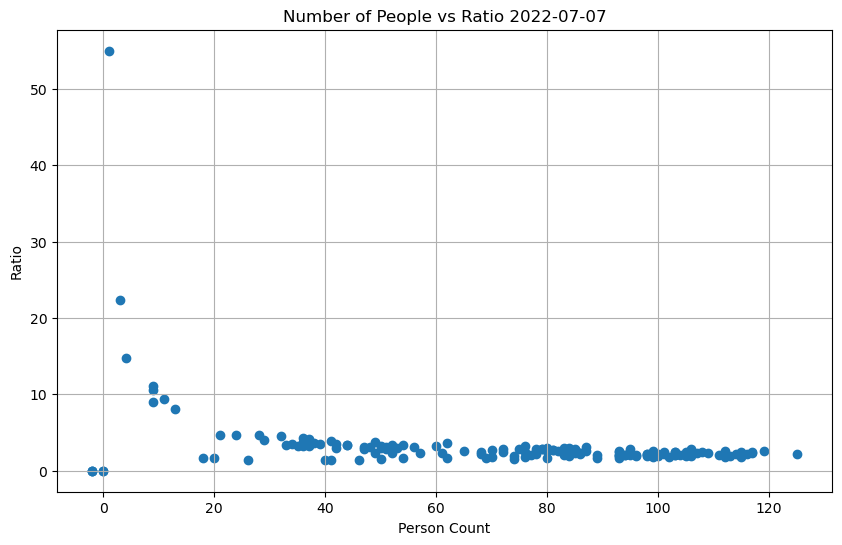

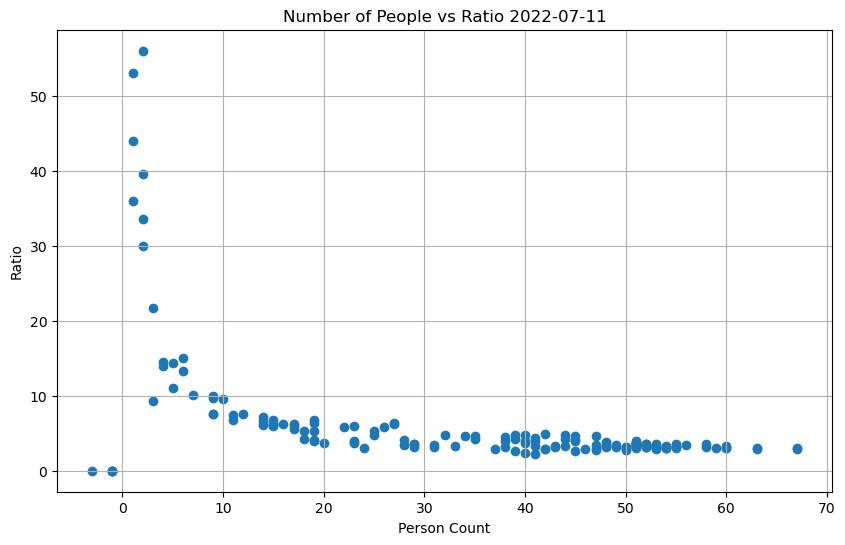

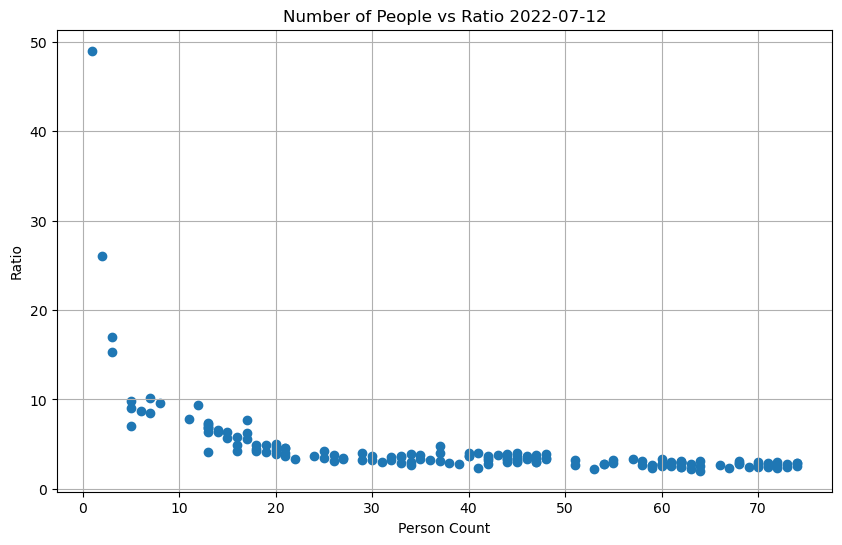

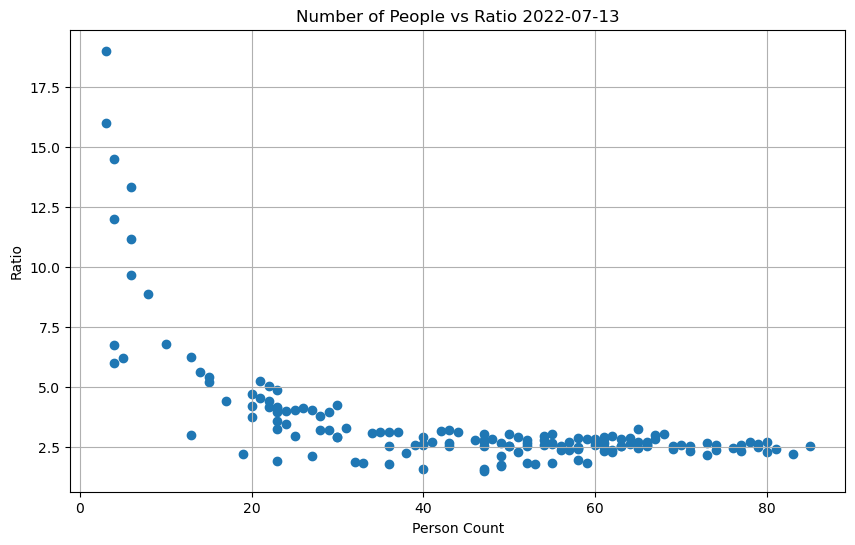

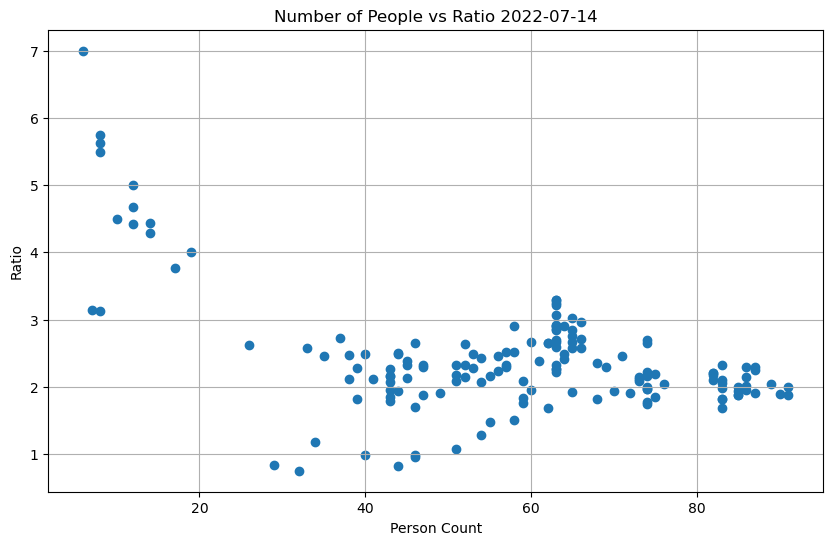

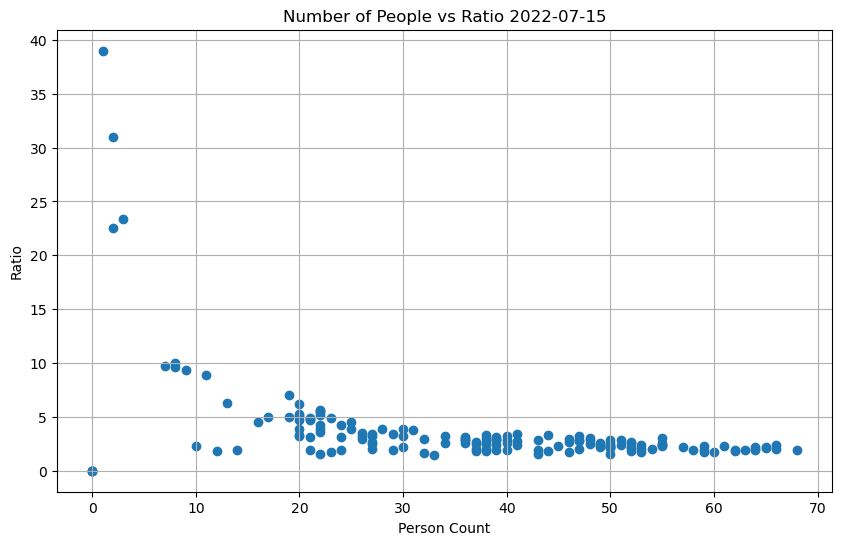

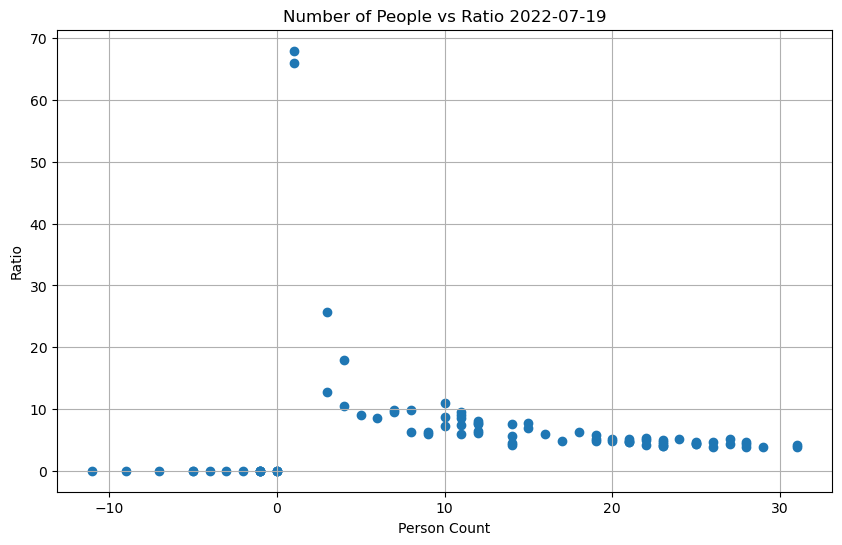

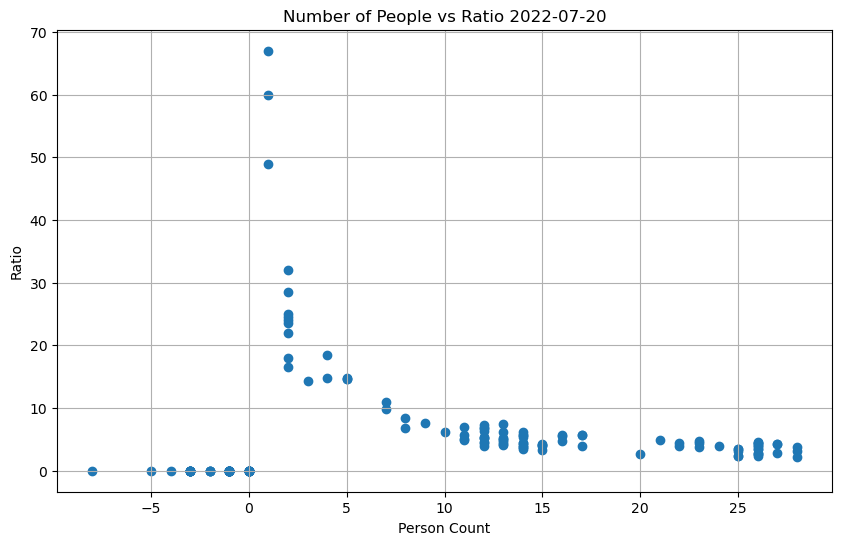

In [581]:
# plotSummaryDay(dataArray, fullPersonCountIntervalArray, rand=False, startHour='8:00:00', finalHour='21:00:00', show=False, offset=False, firstValue='7:00:00', secondValue='21:30:00', interval=30, threshold=70, showDetail=False)
plotSummaryDay(dataLearning, personCountLearning, sample)

## Estudio de la potencia y número de mensajes

La potencia con la que se captan los mensajes también nos puede aportar mucha información, puede indicar que un dispositivo se está alejando o acercando a un receptor, o tal vez que se encuentra fuera del lugar de estudio.

Por ello también sería interesante visualizar tanto el número de paquetes recibidos por un dispositivo como la potencia con la que llegan, ya que si se encuentran pocos paquetes con poca potencia de un dispositivo, seguramente se traten de dispositivos externos o poco relevantes que se pueden eliminar para el cálculo, incorporarlos podría generar ruido en el procesado posterior.

Comenzaremos mostrando la evolución en el número de dispositivos contenidos en unos rangos de potencia variables con respecto a la mínima potencia captada:

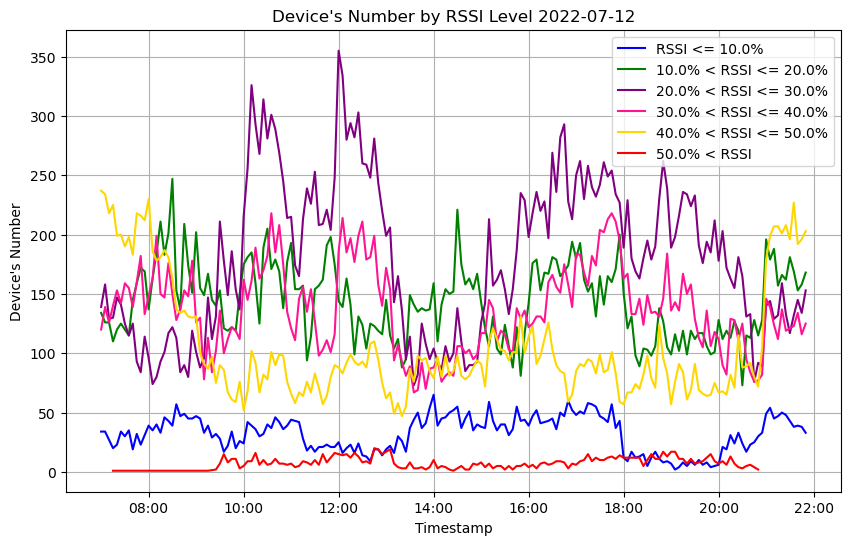

In [582]:
# plotTotalDevicesByRSSI(data, initValue=10, endValue=50)
plotTotalDevicesByRSSI([dataLearning[6]])

Lo más relevante de esta gráfica es que confirma que existen muy pocos dispositivos con alta potencia en recepción (rojo) y los dispositivos con muy poca potencia en recepción tampoco sno mucho mayores a los anteriores mencionados (azul). La mayoría de dispositivos se agrupa en unos niveles de señales medios.

Si nos centramos en el caso particular de cada receptor, podemos conseguir los siguientes resultados:

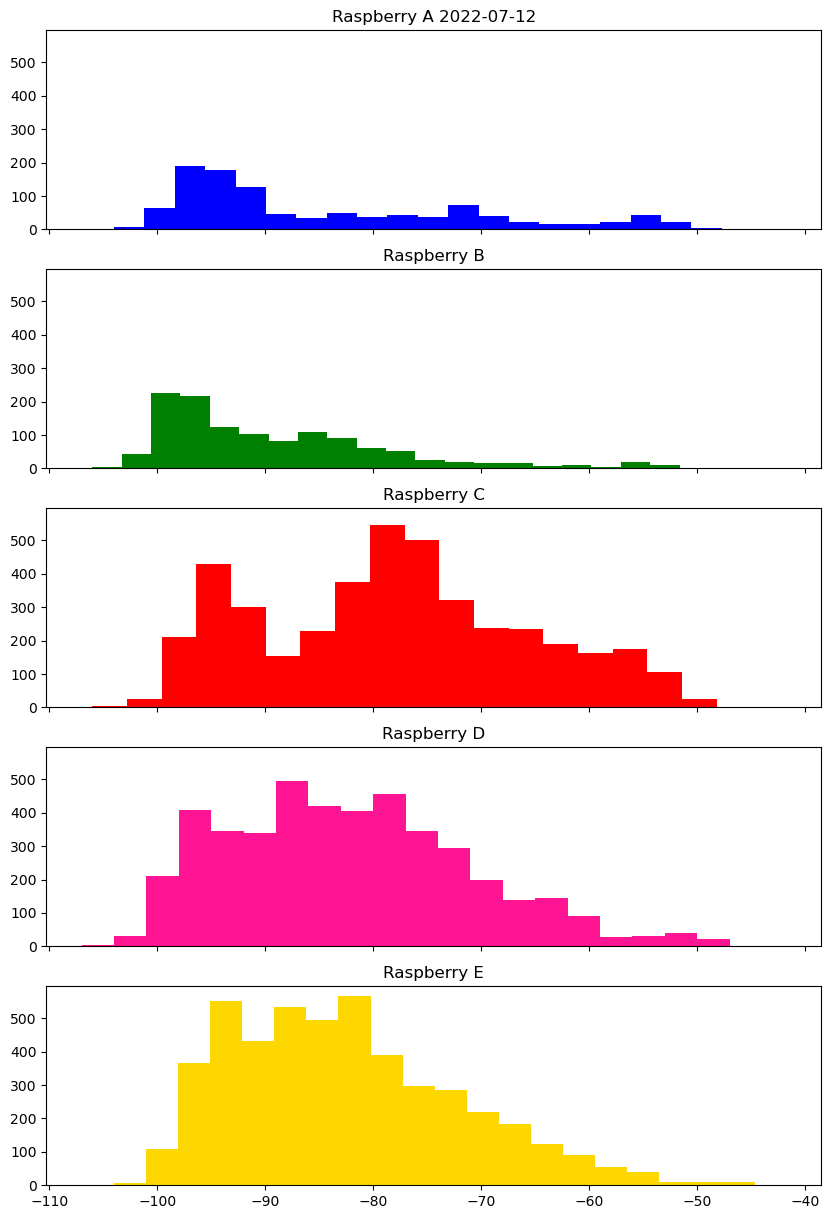

In [583]:
# histTotalDevicesByRSSIAndRaspberry(data, bins=20)
histTotalDevicesByRSSIAndRaspberry([dataLearning[6]])

Para continuar con lo anterior, necesitamos representar el número de mensajes recibidos por cada dispositivo. Sin embargo, esto puede ser costoso, ya que en cada conjunto de datos puede haber muchos dispositivos (miles) lo cual hace imposible su representación. Una posible solución es representar el número de dispositivos que han enviado un cierto número de mensajes, de manera similar al apartado anterior:

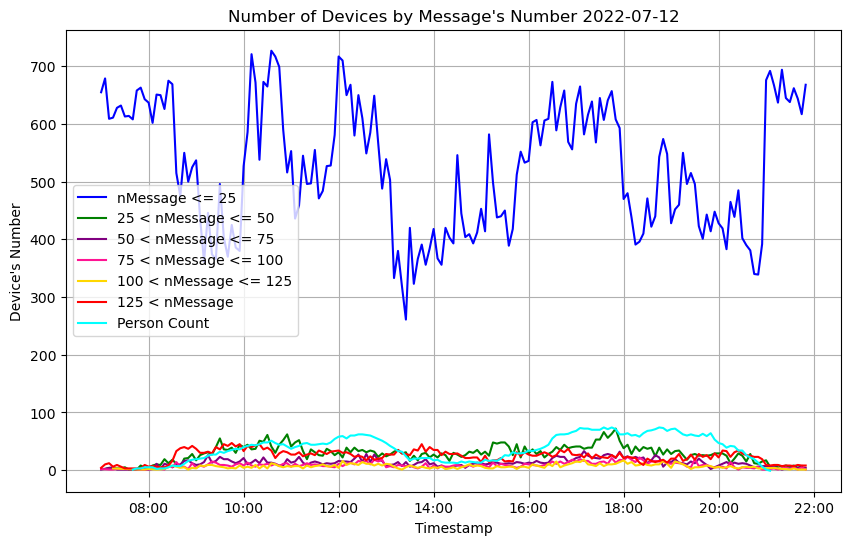

In [584]:
# plotTotalDevicesByMessage(data, personCount, initValue=25, endValue=125, name=None)
plotTotalDevicesByMessage([dataLearning[6]], [personCountLearning[6]])

Resulta curioso que aparezcan tantos dispositivos con un número de mensajes, sobre todo cuando eso indicaría un número de dispositivos mucho mayor al que habiamos obtenido al principio de este notebook. Esto es debido a que cada vez que un dispositivo es registrado por una Raspberry, cuenta como un dispositivo distinto para este experimento, de manera que si en un intervalo de tiempo un dispositivo ha sido captado por los cinco receptores desplegados, la función tomará cinco veces el valor de ese dispositivo en lugar de solo uno.

En principio, existen muchos dispositivos con muy pocos mensajes, lo que hace que el resto de curvas no se lean correctamente. Vamos a reducir la escala para poder apreciarlo mejor:

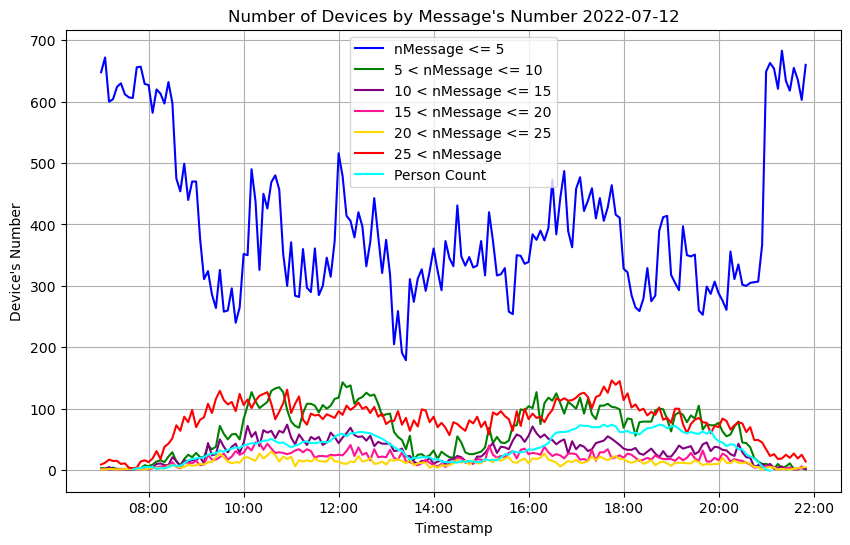

In [585]:
# plotTotalDevicesByMessage(data, personCount, initValue=25, endValue=125, name=None)
plotTotalDevicesByMessage([dataLearning[6]], [personCountLearning[6]], initValue=5, endValue=25)

Con esta nueva vista, podemos asegurar que existen muchos dispositivos que envían muy pocos mensajes dentro del mismo intervalo de tiempo. Esto se debe a lo descrito anteriormente, se registran los dispositivos más veces de las que debería. Sin embargo, este experimento no es tan irrelevante como pueda parecer.
Gracias a esta vista, podemos concluir que hay dispositivos que se mueven mucho por el entorno, por ello no generan una gran cantidad de mensajes en ningún receptor porque no le da tiempo a ello.

Para poder estudiarlo más detalladamente, lo correcto sería filtrarlo por Raspberry para tener una vista más clara de la evolución.

## Estudio del número de mensajes por Raspberry

Un dispositivo solo es registrado una vez por intervalo de tiempo en un receptor, de este modo podemos completar el estudio previo si lo individualizamos para cada receptor.

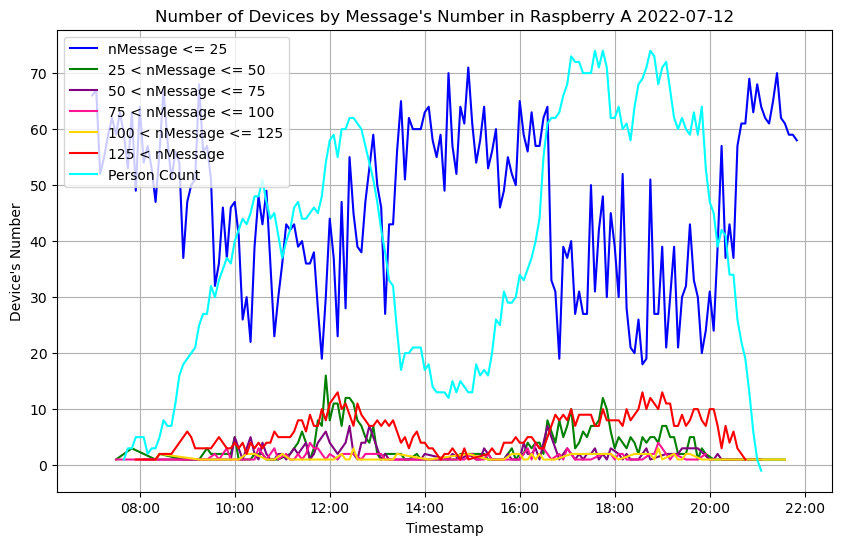

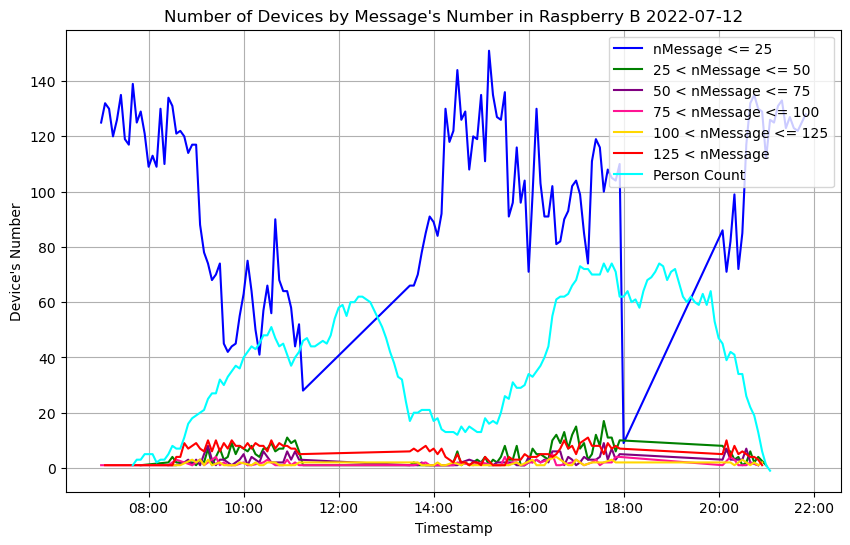

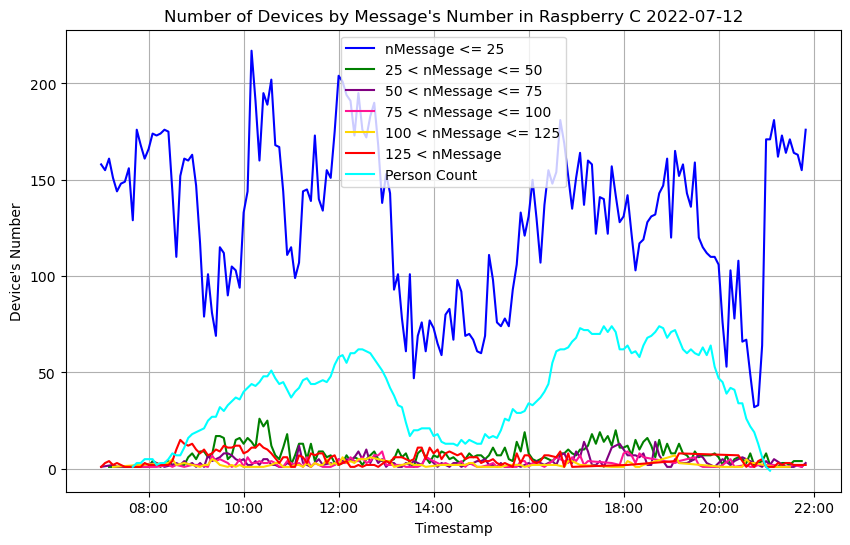

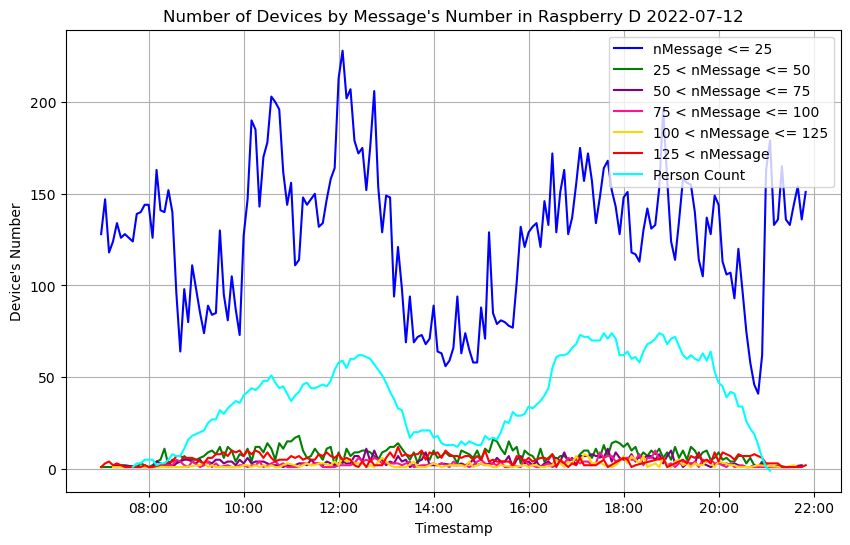

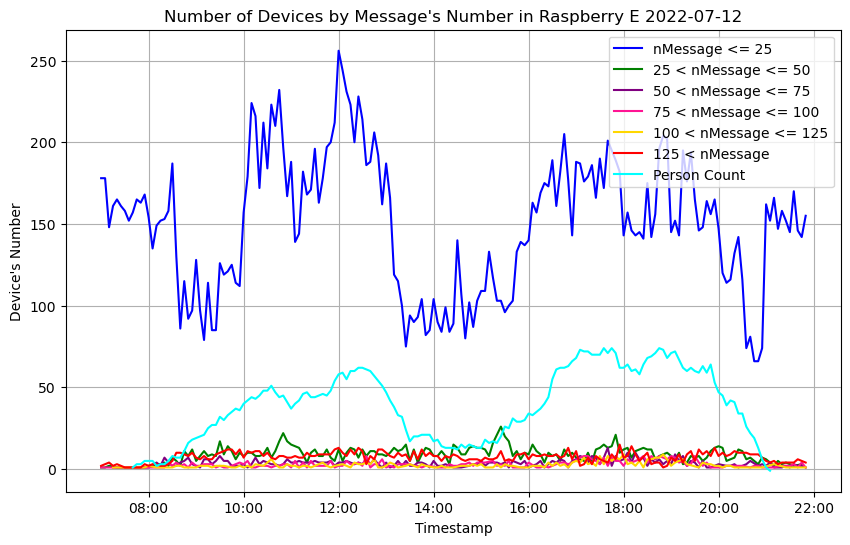

In [586]:
# plotTotalDevicesByMessageByRaspberry(data, personCount, initValue=25, endValue=125)
plotTotalDevicesByMessageByRaspberry([dataLearning[6]], [personCountLearning[6]])

Reduzcamos la escala para poder ver más en detalle la evolución de los dispositivos:

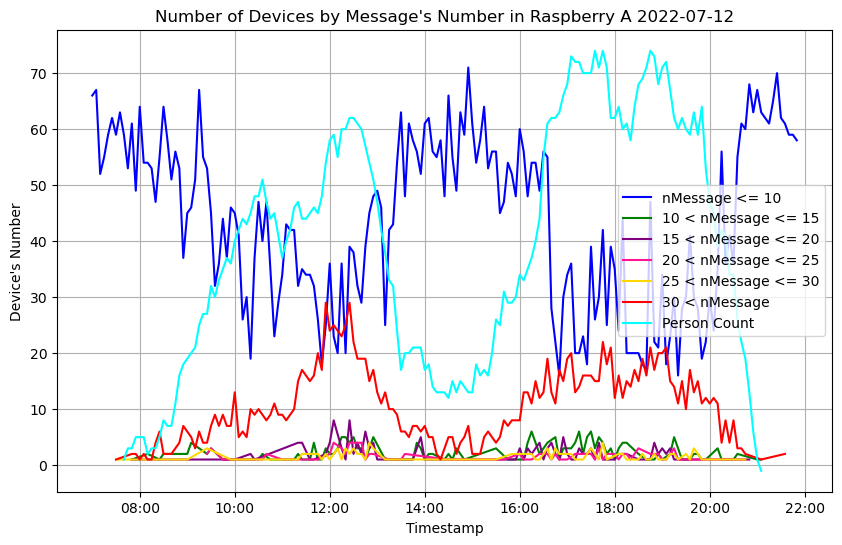

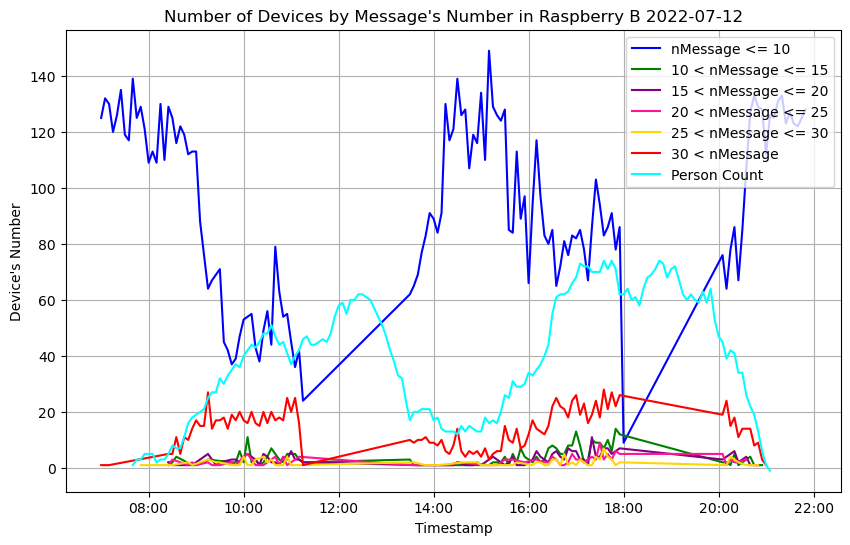

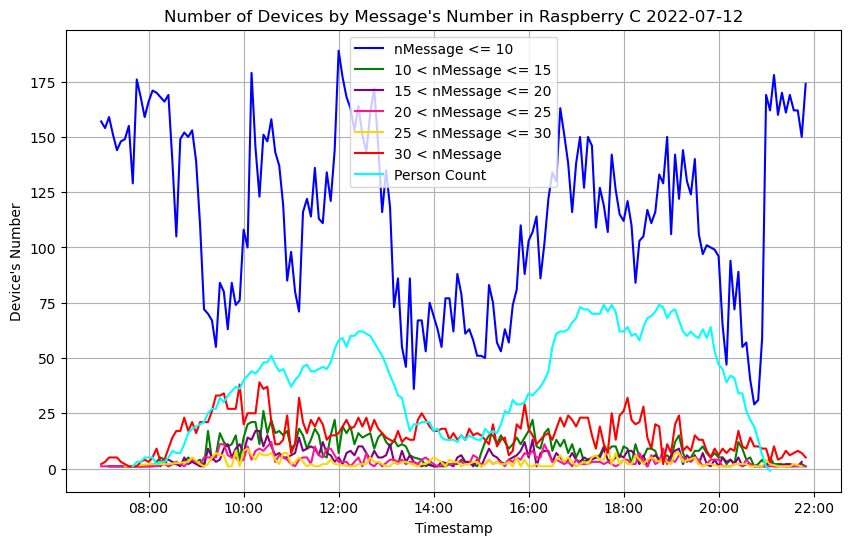

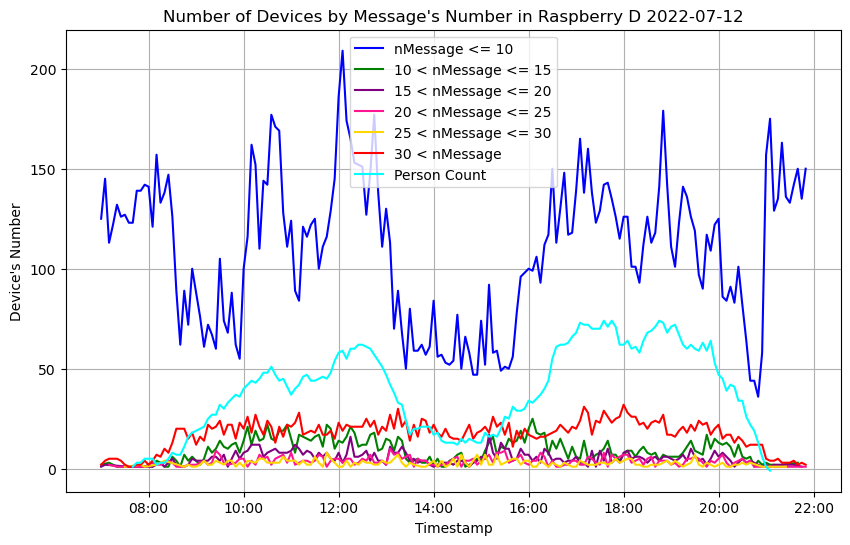

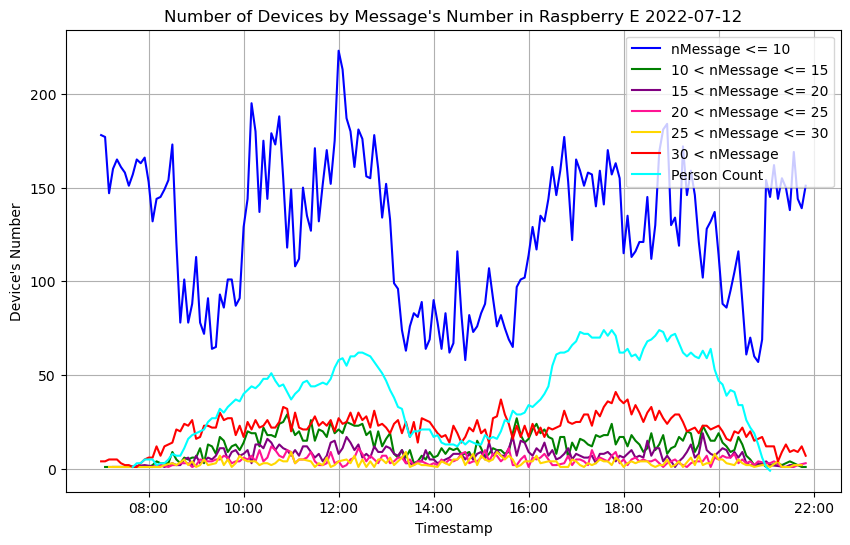

In [587]:
# plotTotalDevicesByMessageByRaspberry(data, personCount, initValue=25, endValue=125)
plotTotalDevicesByMessageByRaspberry([dataLearning[6]], [personCountLearning[6]], initValue=10, endValue=30)

## Estudio de la sala Jose Villena

A partir de ahora, nos centraremos en los receptores desplegados en la principal sala de estudio, es decir, *Raspberry C*, *Raspberry D*, *RaspberryE*. Dado que comparten cobertura y sus evoluciones temporales son parecidas, podemos sacar algunas conclusiones a partir de los datos que nos aportan.

Por ejemplo, el número de direcciones MAC que encuentra cada receptor, que tanto por ciento de paquetes están por debajo de un umbral de potencia, saber si un dispositivo se ha registrado a la vez en más de un receptor o el tanto por ciento de dispositivos que ya estaban registrados durante el intervalo anterior.

In [588]:
# getMetricsRoom(data, RSSIThreshold=-99)
getMetricsRoom([dataLearning[6]])

Métricas para el día 2022-07-12

Número dispositivos captados por la Raspberry C: 4236
Número dispositivos captados por la Raspberry D: 4443
Número dispositivos captados por la Raspberry E: 4782

Número de mensajes captados por la Raspberry C: 447294
Número de mensajes captados por la Raspberry D: 464560
Número de mensajes captados por la Raspberry E: 659978

Tanto por ciento de mensajes por debajo de -99 dB en Raspberry C: 0.0572%
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry D: 0.2381%
Tanto por ciento de mensajes por debajo de -99 dB en Raspberry E: 0.0574

Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry C: 0.5219%
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry D: 1.2357%
Tanto por ciento de dispositivos con mensajes por debajo de -99 dB en Raspberry E: 0.6162%



Como se ha comentado anteriormente, un aspecto que nos puede dar confianza es que un mismo dispositivo sea detectado por más de un receptor en el mismo intervalo de tiempo, para ello recorreremos el datasheet dividido en intervalos de tiempo, comprobando por cuantos y cuáles receptores ha sido capturado ese mensaje.

Los receptores están distribuidos de tal manera que en la sala de estudio, dos de ellos están situados cerca de la pared (Raspberry2 y Raspberry7). Al otro lado de la pared hay un paseo por donde las personas pueden andar. Para intentar filtrar los dispositivos que se encuentran dentro de la biblioteca, podemos discriminarlos de tal manera que deban ser detectados por al menos dos receptores y que estos receptores no sean los que se encuentran instalados en la pared:

                                   MAC  Total
Timestamp                                    
2022-07-12 07:00:00  14:1b:f4:3c:f3:b5      1
2022-07-12 07:00:00  28:de:65:17:e6:6d      1
2022-07-12 07:00:00  28:de:65:17:e6:c6      3
2022-07-12 07:00:00  28:de:65:1d:6f:ce      3
2022-07-12 07:00:00  28:de:65:1d:6f:d8      3
2022-07-12 07:00:00  28:de:65:1d:6f:dc      1
2022-07-12 07:00:00  28:de:65:1d:6f:f9      3
2022-07-12 07:00:00  28:de:65:43:66:dc      2
2022-07-12 07:00:00  28:de:65:43:68:e0      1
2022-07-12 07:00:00  28:de:65:5f:be:d2      1

                    MAC RCDE MAC RCE MAC RDE
Timestamp                                   
2022-07-12 07:00:00        8       8       9
2022-07-12 07:05:00        7       8       8
2022-07-12 07:10:00       10      11      11
2022-07-12 07:15:00       11      11      11
2022-07-12 07:20:00        9       9      10
2022-07-12 07:25:00        7       7       8
2022-07-12 07:30:00        7       8       8
2022-07-12 07:35:00        8       8      

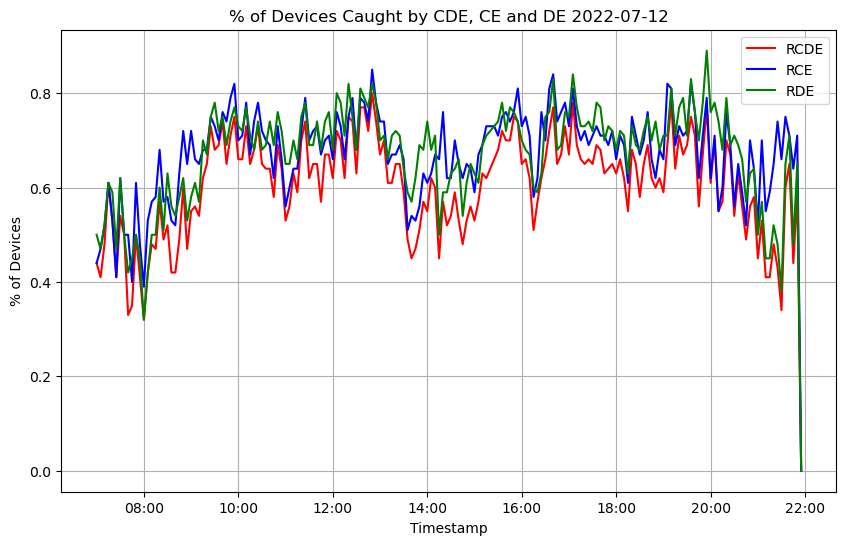

In [589]:
# devicesSummaryList, devicesOverlapList, devicesOverlapRateList = devicesOverlapRoom(data, sampling)
devicesSummaryList, devicesOverlapList, devicesOverlapRateList = devicesOverlapRoom([dataLearning[6]], sample)
# plotDevicesOverlapRoom(deviceOverlapRateList)
plotDevicesOverlapRoom(devicesOverlapRateList)

Al igual que es importante saber si un dispositivo se ha registrado en un mismo receptor en el mismo instante de tiempo, es interesante saber si ese dispositivo estaba previamente registrado, es decir, la continuidad del dispositivo en un receptor a lo largo de los instantes de tiempo, lo que indica que no se ha movido del lugar dándonos más confianza en el dato.

                      MAC   Rate
Timestamp                       
2022-07-12 07:00:00   0.0   0.00
2022-07-12 07:05:00  19.0  86.36
2022-07-12 07:10:00  21.0  77.78
2022-07-12 07:15:00  20.0  83.33
2022-07-12 07:20:00  20.0  95.24
2022-07-12 07:25:00  20.0  95.24
2022-07-12 07:30:00  16.0  88.89
2022-07-12 07:35:00  17.0  80.95
2022-07-12 07:40:00  16.0  94.12
2022-07-12 07:45:00  16.0  66.67


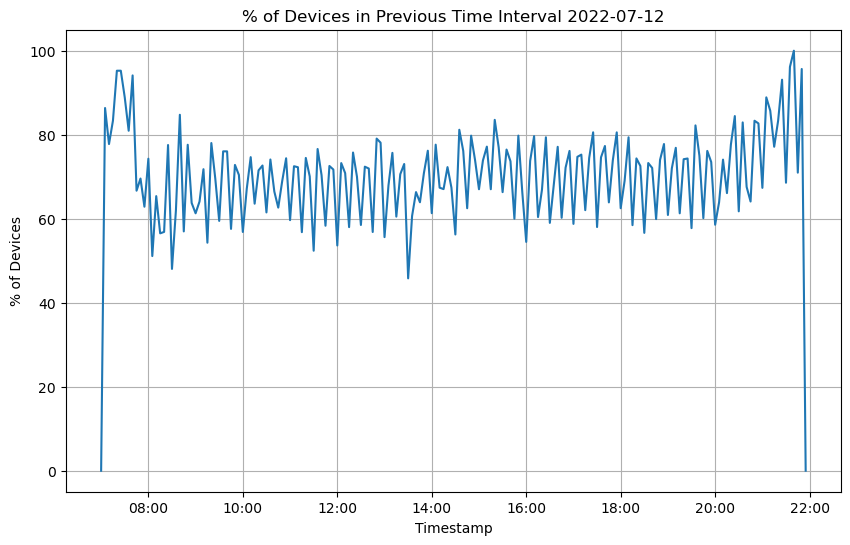

In [590]:
# nDevicesInPreviousIntervalList =  devicesOverlapRoomDetail(data, sampling)
devicesInPreviousInterval = devicesOverlapRoomDetail([dataLearning[6]], sample)
# plotDevicesOverlapRoomDetail(nDevicesInPreviousIntervalList)
plotDevicesOverlapRoomDetail(devicesInPreviousInterval)

Al igual que hemos aplicado el offset en un caso anterior, vamos a aplicarlo para el caso específico de la sala de estudio:

In [591]:
# deviceOverlapOffset = devicesOffsetRoom(data, sampling, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True)
deviceOverlapOffset_20220712 = devicesOffsetRoom([dataLearning[6]], sample)

Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 16
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 22



Número de dispositivos entre las 7:00:00 y las 07:30:00 del día 2022-07-12: 16
Número de dispositivos entre las 21:30:00 y las 22:00:00 del día 2022-07-12: 22



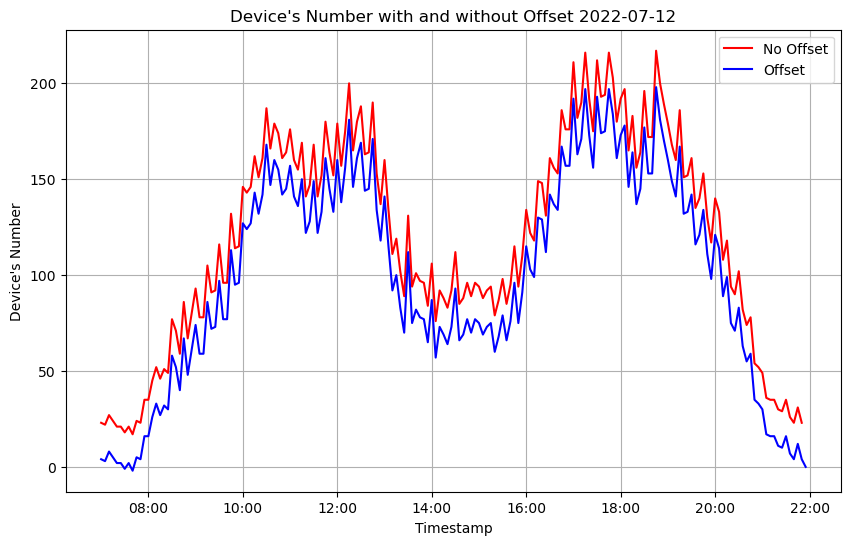

In [592]:
# plotdevicesOffsetRoom(data, sampling, firstValue="7:00:00", secondValue="21:30:00", interval=30, threshold=70, show=True)
plotDevicesOffsetRoom([dataLearning[6]], sample)

Los mapas de correlación son de mucha ayuda, ya que muestran cuan estrecha es la relación entre las columnas de datos. Podemos obtener fácilmente este mapa con lo siguiente:

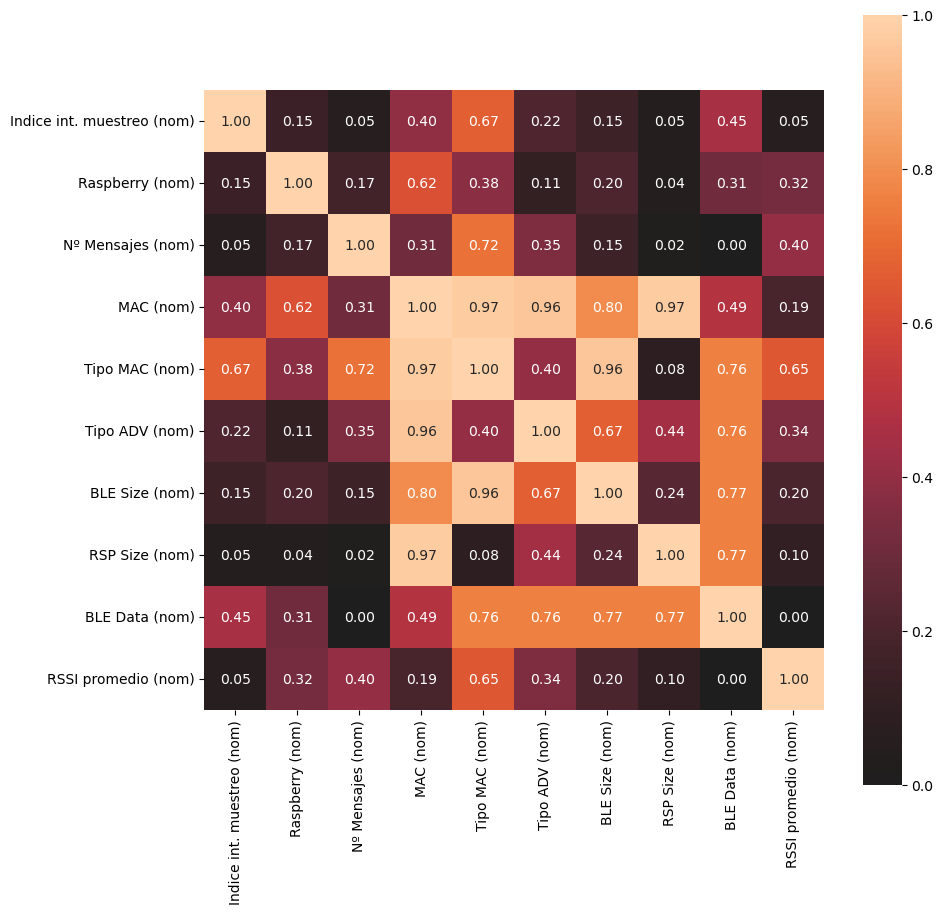

In [593]:
associations(dataLearning[6], figsize=(10, 10), mark_columns=True);